In [32]:
import itertools
from datetime import timedelta

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.signal import windows
from scipy.signal import detrend
from scipy.signal import iirnotch, filtfilt, find_peaks
from scipy.signal.windows import tukey
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import train_test_split

In [4]:
#import the data here
combined_df = pd.read_csv('archive/All_combined.csv')
combined_df['Date'] = pd.to_datetime(combined_df['Date'])
combined_df['Decimal_Year'] = combined_df['Date'].dt.year + (combined_df['Date'].dt.dayofyear - 1) / 365
combined_df.filter(like="Aav")
for name, sub_df in combined_df.groupby('Currency_Name'):
    globals()[name] = sub_df

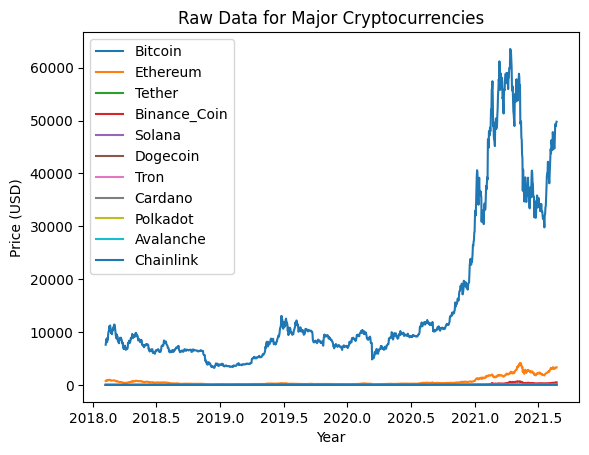

In [97]:
# Select major coins to analyze their trend and correlation

# Plot graph for raw data first
major_coins = [Bitcoin, Ethereum, Tether, Binance_Coin, Solana, Dogecoin, Tron, Cardano, Polkadot, Avalanche, Chainlink]

plt.figure()
legend_labels = set()
for coin in major_coins:
    # As not all coins have data prior to February 2018, filter only the period of timewhere they all have data
    filtered_coin = coin[coin['Decimal_Year'] >= 2018.1]

    label = coin['Currency_Name'].iloc[0]  # Get the coin name
    if label not in legend_labels:  # Avoid duplicate legends
        plt.plot(filtered_coin['Decimal_Year'], filtered_coin['Price'], label=label)
        legend_labels.add(label)
plt.legend()
plt.xlabel('Year')
plt.ylabel('Price (USD)')
plt.title('Raw Data for Major Cryptocurrencies')
plt.show()

<Figure size 640x480 with 0 Axes>

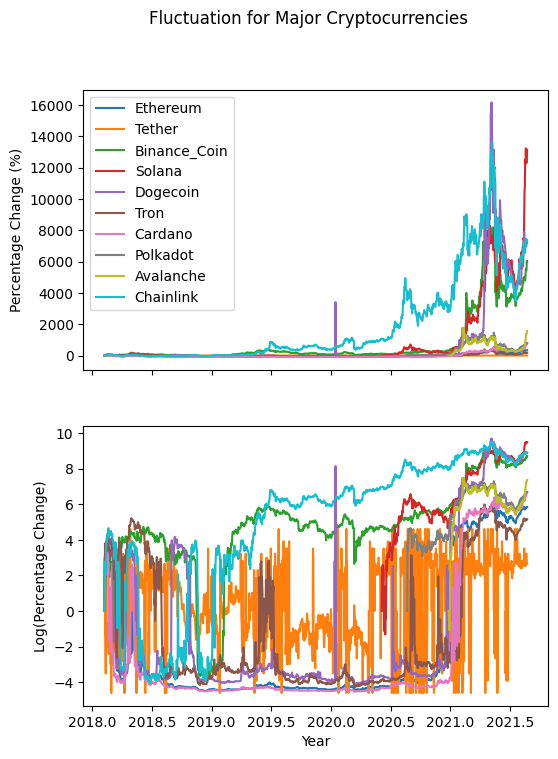

In [6]:
for coin in major_coins:
    reference_row = coin[coin['Decimal_Year'] >= 2018.1].iloc[0]
    reference_price = reference_row['Price']
    # Calculate percent change for each price in the data
    coin['Percent_Change'] = ((coin['Price'] - reference_price) / reference_price) * 100

def log_neg(array):
    """Define a function that takes a numpy array and returns a logarithmic scale."""
    output = []
    for r in array:
        if r == 0:
            output.append(0)
        elif r < 0:
            output.append(-np.log(-r))
        else:
            output.append(np.log(r))
    return output


plt.figure()
legend_labels = set()

f, ax = plt.subplots(2, 1, sharex=True, squeeze=False, figsize=(6, 8))
for coin in major_coins[1:]:
    filtered_coin = coin[coin['Decimal_Year'] >= 2018.1]

    label = coin['Currency_Name'].iloc[0]  # Get the coin name
    if label not in legend_labels:  # Avoid duplicate legends
        ax[0, 0].plot(filtered_coin['Decimal_Year'], filtered_coin['Percent_Change'], label=label)
        legend_labels.add(label)

        ax[1, 0].plot(filtered_coin['Decimal_Year'], log_neg(filtered_coin['Percent_Change']), label=label)

ax[0, 0].set_ylabel('Percentage Change (%)')
ax[1, 0].set_ylabel('Log(Percentage Change)')
ax[1, 0].set_xlabel('Year')

ax[0, 0].legend()

f.suptitle('Fluctuation for Major Cryptocurrencies')
plt.show()

In [7]:
def windowed_fourier_transform(coin):
    filtered_coin = coin[coin['Decimal_Year'] >= 2018.1]
    decimal_year = filtered_coin['Decimal_Year']
    data = filtered_coin['Percent_Change']

    dt = np.mean(np.diff(decimal_year))
    N = len(decimal_year)

    window = windows.hamming(N)
    windowed_data = data * window
    fft_val = np.fft.fft(windowed_data)
    freq = np.fft.fftfreq(N, dt)

    return fft_val, freq, window

/Users/corinnama/PycharmProjects/PHY408 Labs/.venv/.venv/lib/python3.13/site-packages/matplotlib/cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/corinnama/PycharmProjects/PHY408 Labs/.venv/.venv/lib/python3.13/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


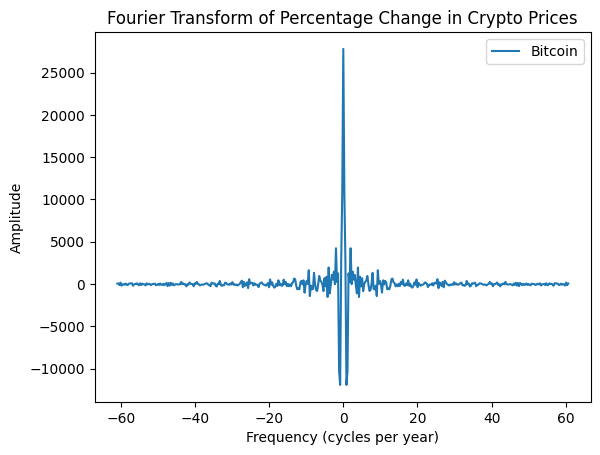

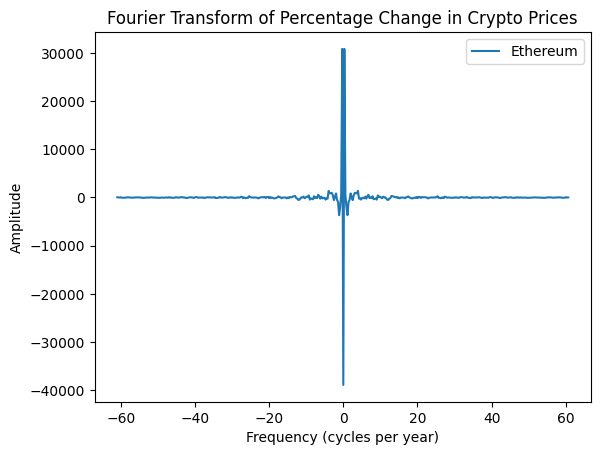

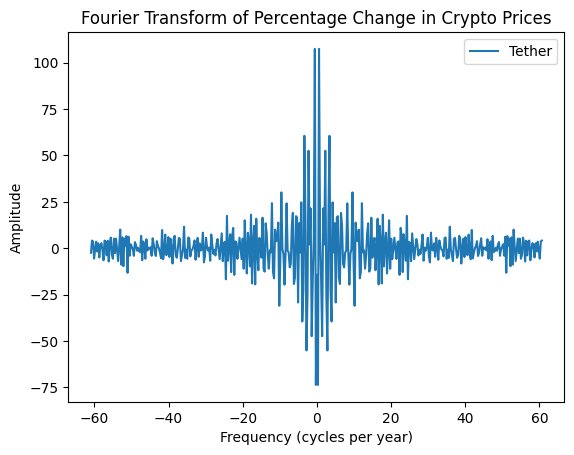

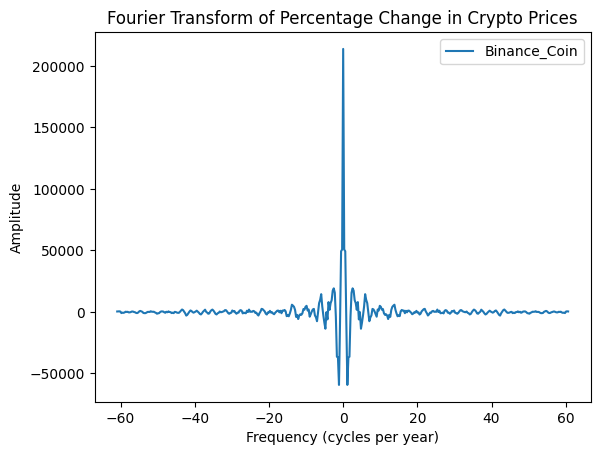

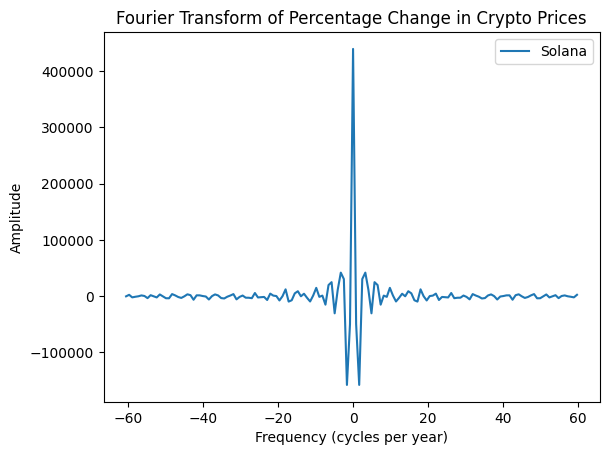

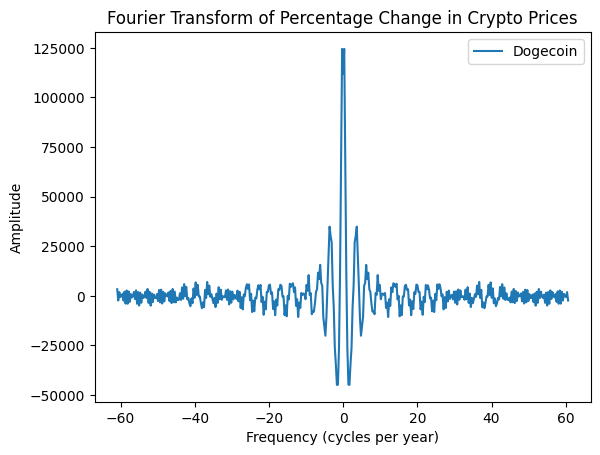

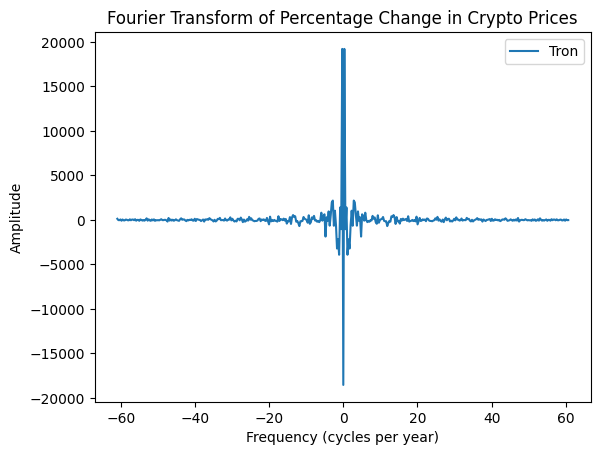

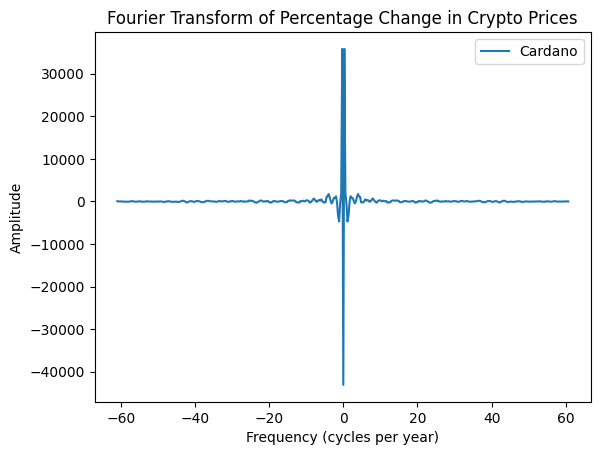

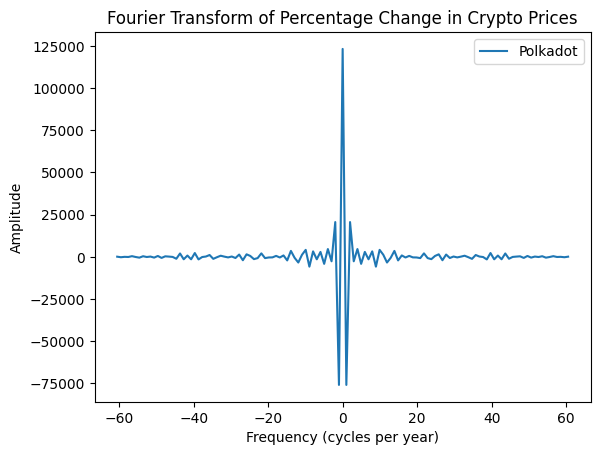

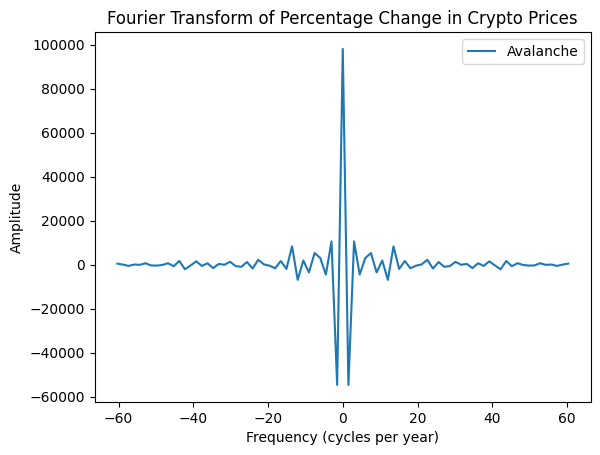

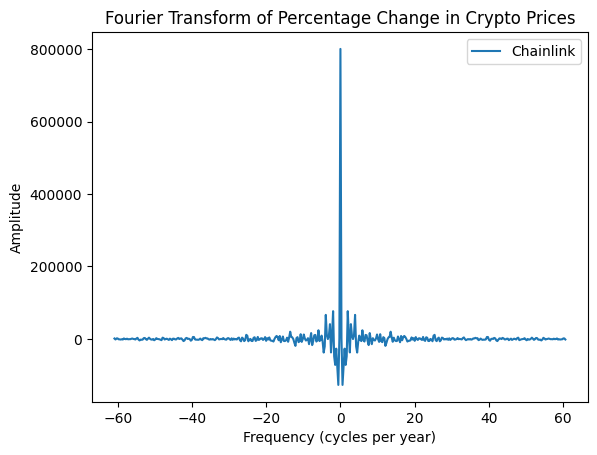

In [88]:
legend_labels = set()
fft_vals, freqs, trend, detrend = [], [], [], []
threshold = 6
for coin in major_coins:
    plt.figure()
    label = coin['Currency_Name'].iloc[0]  # Get the coin name
    if label not in legend_labels:  # Avoid duplicate legends
        # Get FFT values, frequency axis, and the window function
        fft_val, freq, window = windowed_fourier_transform(coin)

        # Copy for thresholding
        trend_fft_val = fft_val.copy()
        trend_freq = freq.copy()

        fft_val = np.fft.fftshift(fft_val)
        freq = np.fft.fftshift(freq)
        fft_vals.append(fft_val)
        freqs.append(freq)

        # Threshold in the unshifted domain: zero out high frequencies
        high_freq_indices = np.abs(trend_freq) > threshold
        trend_fft_val[high_freq_indices] = 0

        # Inverse FFT to get the trend; preserve phase
        trend_signal = np.real(np.fft.ifft(trend_fft_val))

        # Recover the trend signal by diving out the window (for nonzero indices)
        recovered_trend = np.empty_like(trend_signal)
        nonzero_indices = window != 0
        recovered_trend[nonzero_indices] = trend_signal[nonzero_indices] / window[nonzero_indices]
        recovered_trend[~nonzero_indices] = trend_signal[~nonzero_indices]

        # Save recovered trend
        trend.append(recovered_trend)
        filtered_coin = coin[coin['Decimal_Year'] >= 2018.1]
        detrend.append(filtered_coin['Percent_Change'] - recovered_trend)
        plt.plot(freq[len(freq)//3:-len(freq)//3], fft_val[len(freq)//3:-len(freq)//3], label=label)
        legend_labels.add(label)

    plt.xlabel('Frequency (cycles per year)')
    plt.ylabel('Amplitude')
    plt.title('Fourier Transform of Percentage Change in Crypto Prices')
    plt.legend()
    plt.savefig('Fourier Transform of Percentage Change in Crypto Prices'+label+'.png')
    plt.show()

In [69]:
# Find peaks in FFT for coin prices
for i in range(len(major_coins)):
    mag = np.abs(fft_vals[i])
    # Consider only the positive frequencies
    positive = freqs[i] > 0
    freq_pos = freqs[i][positive]
    mag_pos = mag[positive]

    # Find peaks in the magnitude spectrum
    peaks, _ = find_peaks(mag_pos, height=0)
    sorted_peaks = peaks[np.argsort(mag_pos[peaks])][::-1]

    num_peaks_to_print = 3
    for j in range(min(num_peaks_to_print, len(sorted_peaks))):
        peak_idx = sorted_peaks[i]
        print(f"Peak {j+1}: Frequency = {freq_pos[peak_idx]:.4f} Cycle/Year, Amplitude = {mag_pos[peak_idx]:.4f}")

Peak 1: Frequency = 3.3849 Cycle/Year, Amplitude = 3054.9795
Peak 2: Frequency = 3.3849 Cycle/Year, Amplitude = 3054.9795
Peak 3: Frequency = 3.3849 Cycle/Year, Amplitude = 3054.9795
Peak 1: Frequency = 3.9490 Cycle/Year, Amplitude = 1852.9187
Peak 2: Frequency = 3.9490 Cycle/Year, Amplitude = 1852.9187
Peak 3: Frequency = 3.9490 Cycle/Year, Amplitude = 1852.9187
Peak 1: Frequency = 2.5386 Cycle/Year, Amplitude = 73.4275
Peak 2: Frequency = 2.5386 Cycle/Year, Amplitude = 73.4275
Peak 3: Frequency = 2.5386 Cycle/Year, Amplitude = 73.4275
Peak 1: Frequency = 2.2566 Cycle/Year, Amplitude = 23105.5301
Peak 2: Frequency = 2.2566 Cycle/Year, Amplitude = 23105.5301
Peak 3: Frequency = 2.2566 Cycle/Year, Amplitude = 23105.5301
Peak 1: Frequency = 16.3676 Cycle/Year, Amplitude = 14825.1189
Peak 2: Frequency = 16.3676 Cycle/Year, Amplitude = 14825.1189
Peak 3: Frequency = 16.3676 Cycle/Year, Amplitude = 14825.1189
Peak 1: Frequency = 6.2056 Cycle/Year, Amplitude = 15685.2214
Peak 2: Frequency = 

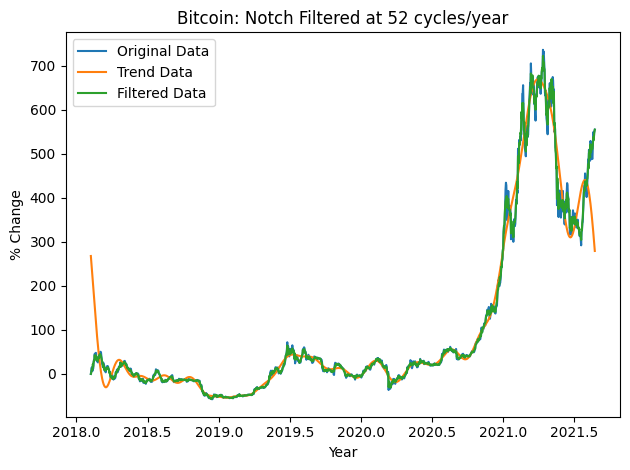

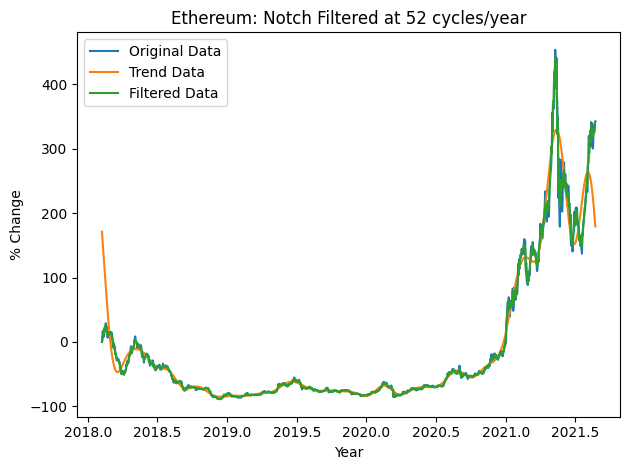

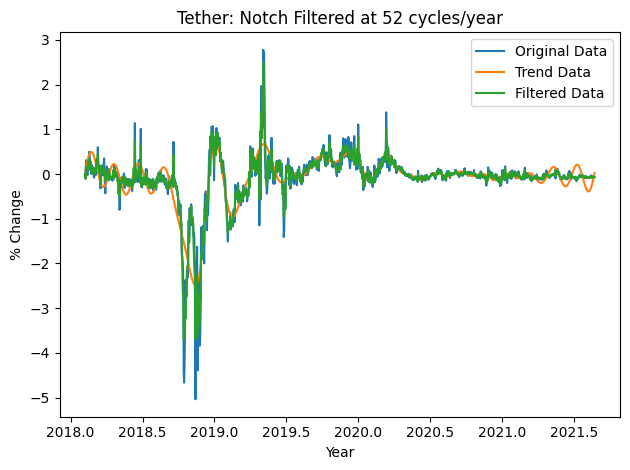

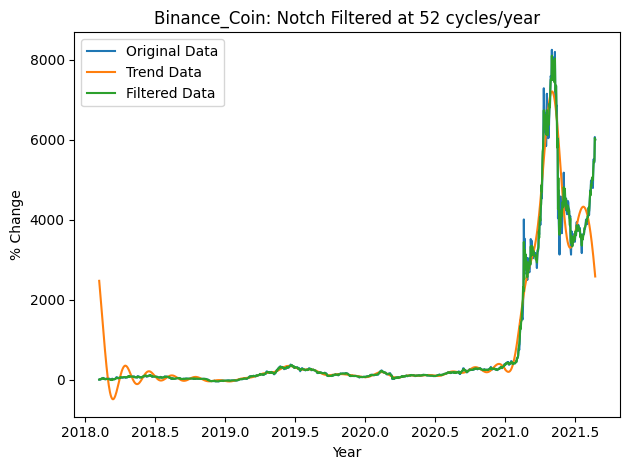

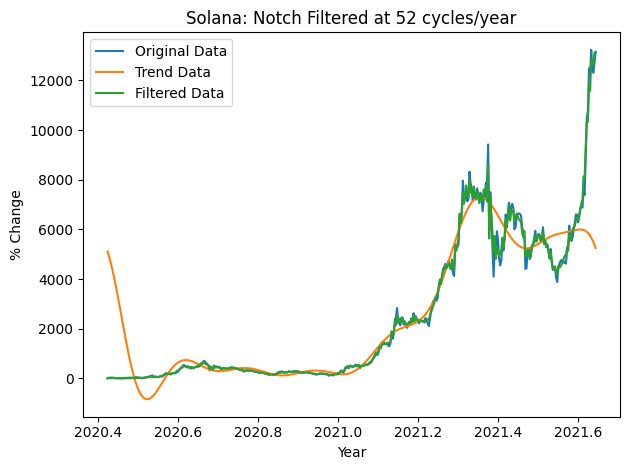

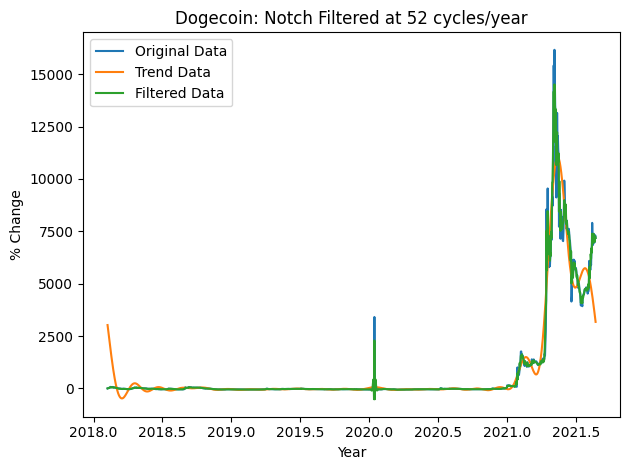

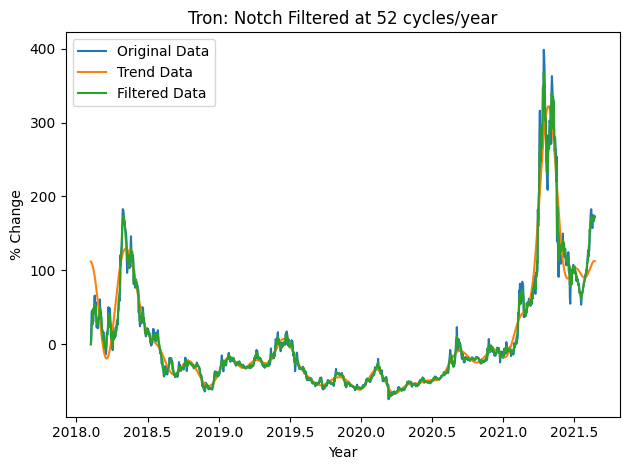

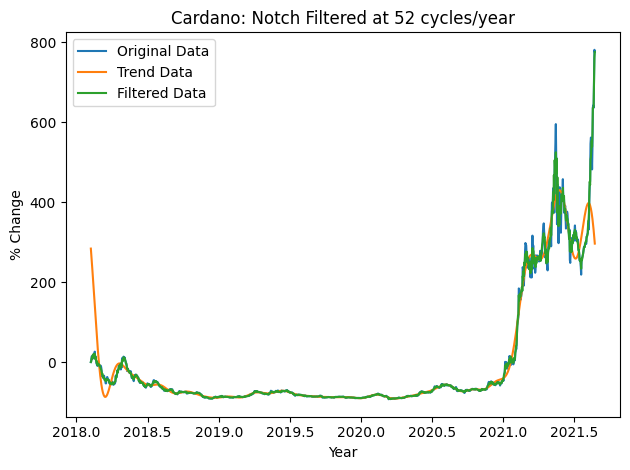

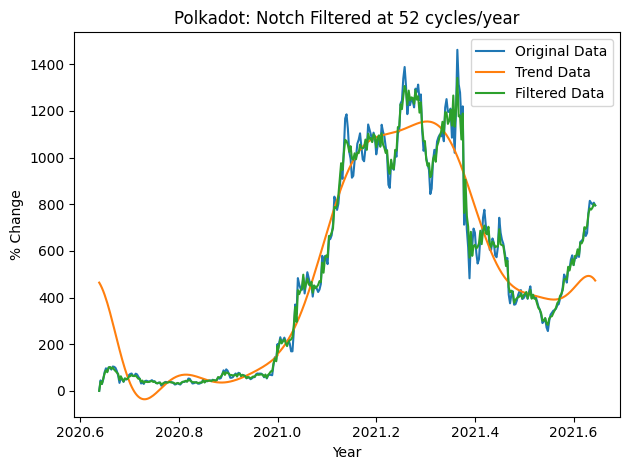

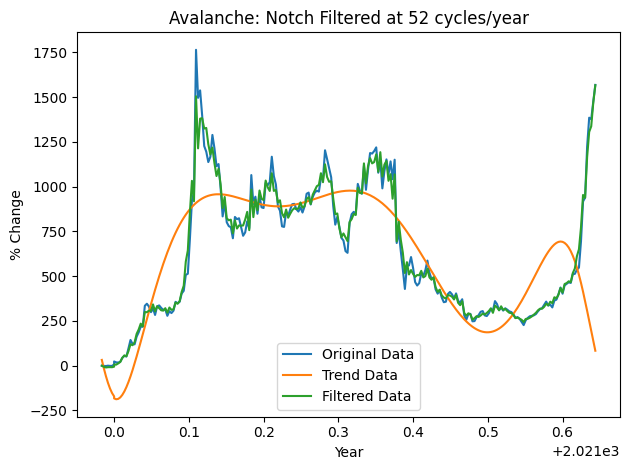

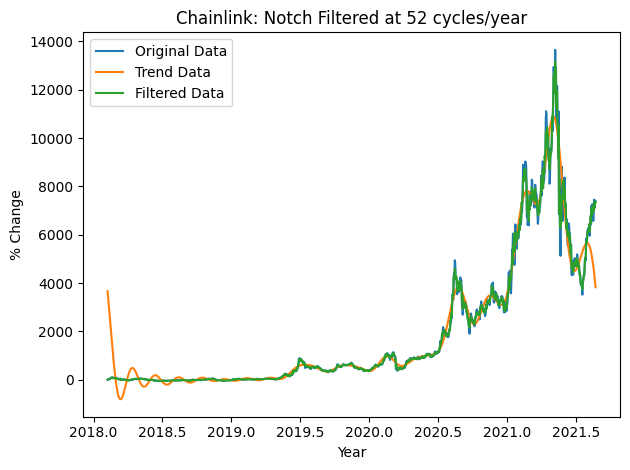

In [115]:
f0 = 365/7
Q = 1
fs = 365

b, a = iirnotch(f0, Q, fs)
# Apply to each coin
for i in range(len(major_coins)):
    mask = major_coins[i]['Decimal_Year'] >= 2018.1
    filtered_coin = major_coins[i][mask].copy()

    detrended = detrend[i]
    filtered_signal = filtfilt(b, a, detrended)
    filtered_coin['Filtered'] = filtered_signal
    filtered_coin['Filter_With_Trend'] = np.real(filtered_signal + trend[i])

    plt.figure()
    plt.plot(filtered_coin['Decimal_Year'], filtered_coin['Percent_Change'], label='Original Data')
    plt.plot(filtered_coin['Decimal_Year'], trend[i], label='Trend Data')
    plt.plot(filtered_coin['Decimal_Year'], filtered_coin['Filter_With_Trend'], label='Filtered Data')
    plt.xlabel('Year')
    plt.ylabel('% Change')
    plt.title(f"{major_coins[i]['Currency_Name'].iloc[0]}: Notch Filtered at 52 cycles/year")
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"Notch_Filtered_6_cycles_per_year_{major_coins[i]['Currency_Name'].iloc[0]}.png")
    plt.show()

In [ ]:
# Use SARIMA model to predict future trend

In [10]:
# Define the test for differencing
def adf_test(series, signif=0.05, title=''):
    """
    Perform the Augmented Dickey Fuller Test and print the results
    :param series: time series to test
    :param signif: significance level (default 0.05)
    :param title: title to print for the series being tested
    :return: p-value from the test
    """
    result = adfuller(series)
    print(f'ADF Statistic for {title}: {result[0]:.4f}')
    print(f'p-value for {title}: {result[1]:.4f}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'   {key}: {value:.4f}')
    return result[1]

In [43]:
# Incorporate S&P 500
for coin in major_coins:
    coin['LogPrice'] = np.log(coin['Price'])
# Load S&P 500 data
sp500 = pd.read_csv('S&P500HistoricalData.csv')
sp500['Date'] = pd.to_datetime(sp500['Date'], format='%m/%d/%Y')
sp500['Decimal_Year'] = sp500['Date'].dt.year + (sp500['Date'].dt.dayofyear - 1) / 365
sp500.set_index('Date', inplace=True)
sp500.sort_index(inplace=True)

# filter the S&P 500 Data
max_cryto_year = Bitcoin['Decimal_Year'].max()
sp500 = sp500[(sp500['Decimal_Year'] >= 2018.1) & (sp500['Decimal_Year'] <= max_cryto_year)]

# Compute a representative price
sp500['MeanPrice'] = sp500[['Open', 'High', 'Low', 'Close']].mean(axis=1)

Date
2018-02-07    2018.101370
2018-02-08    2018.104110
2018-02-09    2018.106849
2018-02-12    2018.115068
2018-02-13    2018.117808
                 ...     
2021-08-18    2021.627397
2021-08-19    2021.630137
2021-08-20    2021.632877
2021-08-23    2021.641096
2021-08-24    2021.643836
Name: Decimal_Year, Length: 893, dtype: float64


In [41]:
# Or maybe not, correlation graph not displaying properly
# Determine correlation type between stock market price and cryptocurrency price
def lagged_correlation(series1, series2, max_lag):
    """
    Compute the correlation coefficients between two series
    :param series1: pandas series
    :param series2: pandas series (will be shifted)
    :param max_lag: maximum lag (positive and negative)
    :return: A dataframe with lags and their corresponding correlation coefficients
    """
    lags = range(-max_lag, max_lag+1)
    correlations = []
    for lag in lags:
        if lag < 0:
            corr = series1.shift(-lag).corr(series2)
        else:
            corr = series1.corr(series2.shift(lag))
        correlations.append(corr)
    return pd.DataFrame({'lag': lags, 'correlation': correlations})

In [42]:
merged = pd.merge(
    Bitcoin[['Price']],
    sp500[['MeanPrice']],
    left_index=True,
    right_index=True,
    how='inner',  # Keep only overlapping dates
    suffixes=('_BTC', '_SP500')
)
print(f"Merged data shape: {merged.shape}")

print("Merged Data Inspection:")
print(f"Start Date: {merged.index.min()}, End Date: {merged.index.max()}")
print(f"Number of Data Points: {len(merged)}")
print("\nFirst 5 Rows:")
print(merged.head())

Merged data shape: (0, 2)
Merged Data Inspection:
Start Date: nan, End Date: nan
Number of Data Points: 0

First 5 Rows:
Empty DataFrame
Columns: [Price, MeanPrice]
Index: []


In [86]:
# Reindex S&P500 to a full daily date range and interpolate missing data
full_date_range = pd.date_range(start=sp500.index.min(), end=sp500.index.max(), freq='D')
sp500 = sp500.reindex(full_date_range)
sp500 = sp500.interpolate(method='polynomial', order=2)
sp500.index.name = 'Date'

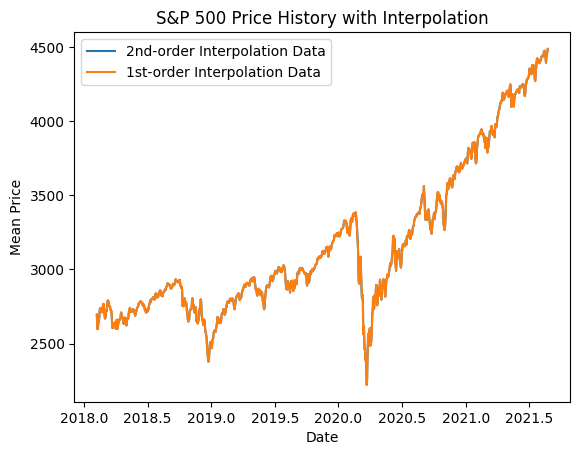

In [87]:
plt.figure()
plt.plot(sp500['Decimal_Year'], sp500['MeanPrice'], label='Interpolated Data')
plt.xlabel('Date')
plt.ylabel('Mean Price')
plt.title('S&P 500 Price History with Interpolation')
plt.savefig('S&P 500 Price History with Interpolation.png')
plt.show()

ADF Statistic for Bitcoin: -2.3730
p-value for Bitcoin: 0.1495
Critical Values:
   1%: -3.4320
   5%: -2.8623
   10%: -2.5672
ADF Statistic for Differenced Series (d=1): -24.1247
p-value for Differenced Series (d=1): 0.0000
Critical Values:
   1%: -3.4320
   5%: -2.8623
   10%: -2.5672

The series is stationary after 1 differencing(s).


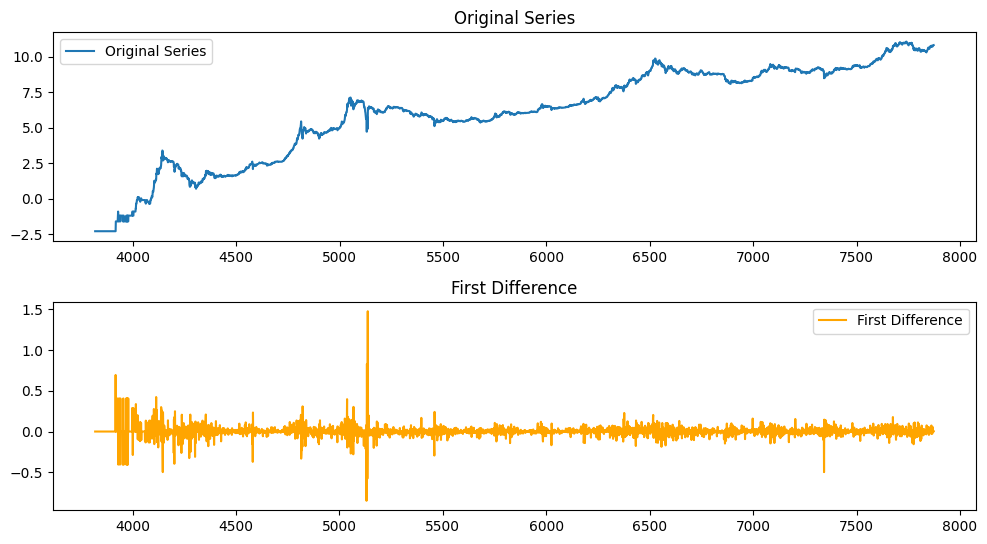

ADF Statistic for Ethereum: -0.6476
p-value for Ethereum: 0.8599
Critical Values:
   1%: -3.4336
   5%: -2.8630
   10%: -2.5675
ADF Statistic for Differenced Series (d=1): -30.5888
p-value for Differenced Series (d=1): 0.0000
Critical Values:
   1%: -3.4336
   5%: -2.8630
   10%: -2.5675

The series is stationary after 1 differencing(s).


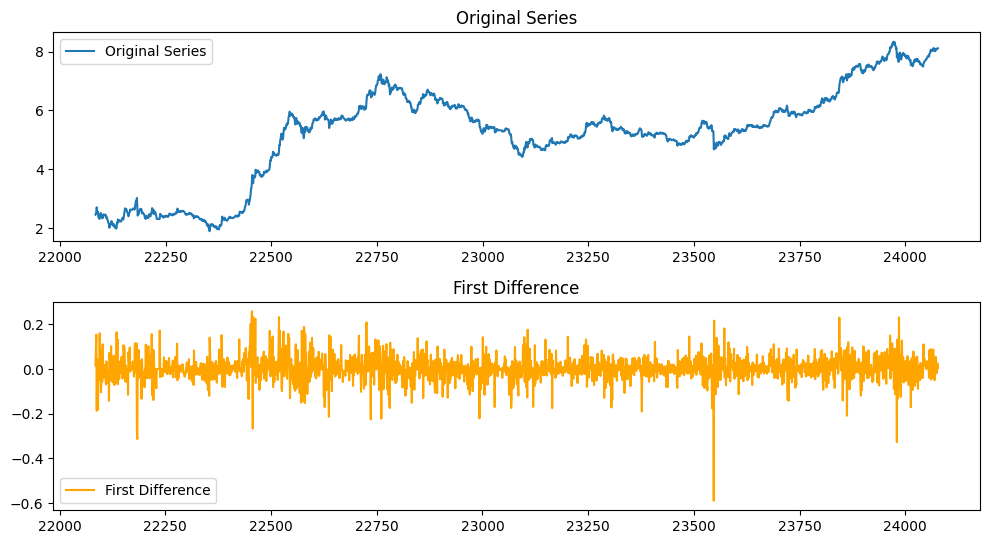

ADF Statistic for Tether: -8.2000
p-value for Tether: 0.0000
Critical Values:
   1%: -3.4345
   5%: -2.8634
   10%: -2.5678

The series is stationary after 0 differencing(s).


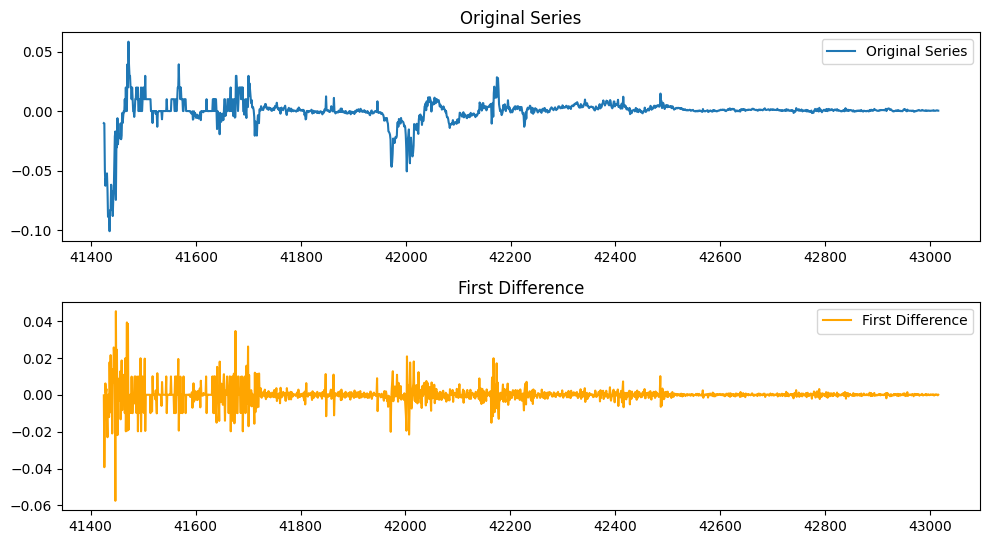

ADF Statistic for Binance_Coin: -0.9555
p-value for Binance_Coin: 0.7691
Critical Values:
   1%: -3.4351
   5%: -2.8636
   10%: -2.5679
ADF Statistic for Differenced Series (d=1): -9.9415
p-value for Differenced Series (d=1): 0.0000
Critical Values:
   1%: -3.4351
   5%: -2.8636
   10%: -2.5679

The series is stationary after 1 differencing(s).


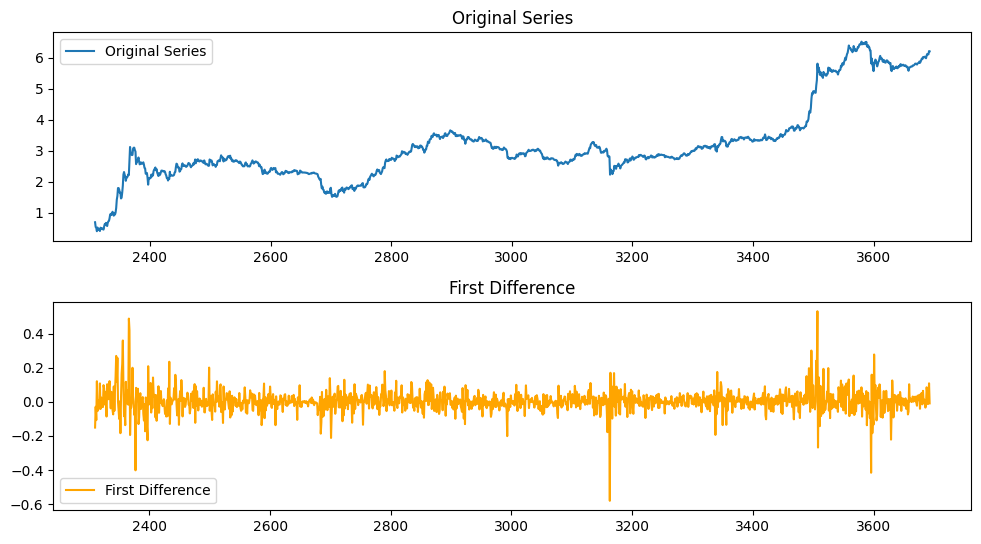

ADF Statistic for Solana: -0.3916
p-value for Solana: 0.9115
Critical Values:
   1%: -3.4452
   5%: -2.8681
   10%: -2.5703
ADF Statistic for Differenced Series (d=1): -23.5338
p-value for Differenced Series (d=1): 0.0000
Critical Values:
   1%: -3.4452
   5%: -2.8681
   10%: -2.5703

The series is stationary after 1 differencing(s).


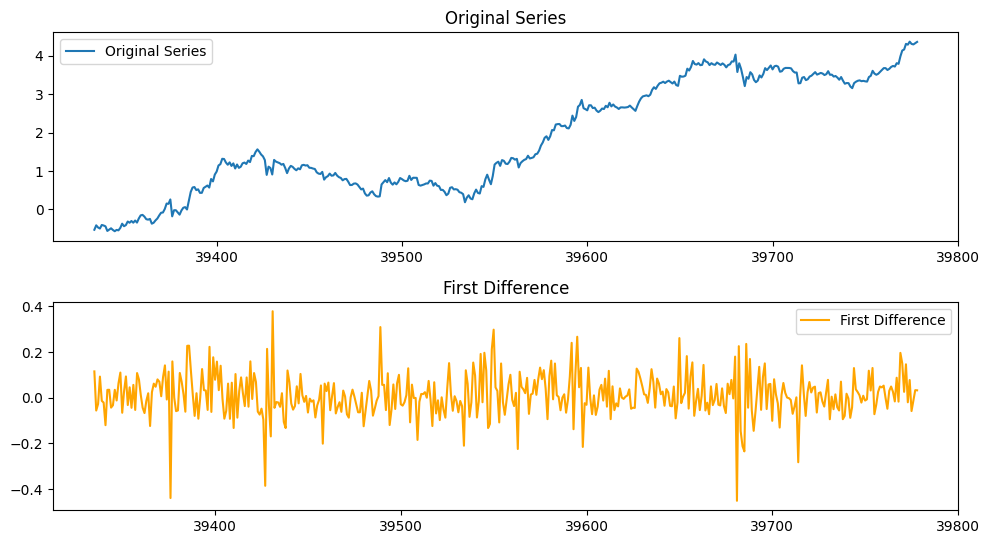

ADF Statistic for Dogecoin: 0.3605
p-value for Dogecoin: 0.9800
Critical Values:
   1%: -3.4346
   5%: -2.8634
   10%: -2.5678
ADF Statistic for Differenced Series (d=1): -28.9187
p-value for Differenced Series (d=1): 0.0000
Critical Values:
   1%: -3.4346
   5%: -2.8634
   10%: -2.5678

The series is stationary after 1 differencing(s).


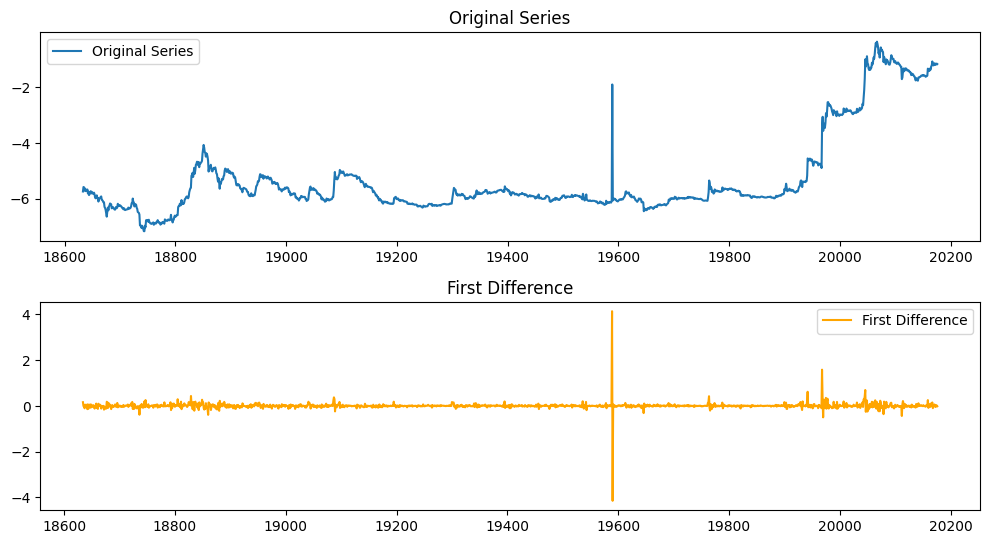

ADF Statistic for Tron: -4.9505
p-value for Tron: 0.0000
Critical Values:
   1%: -3.4352
   5%: -2.8637
   10%: -2.5679

The series is stationary after 0 differencing(s).


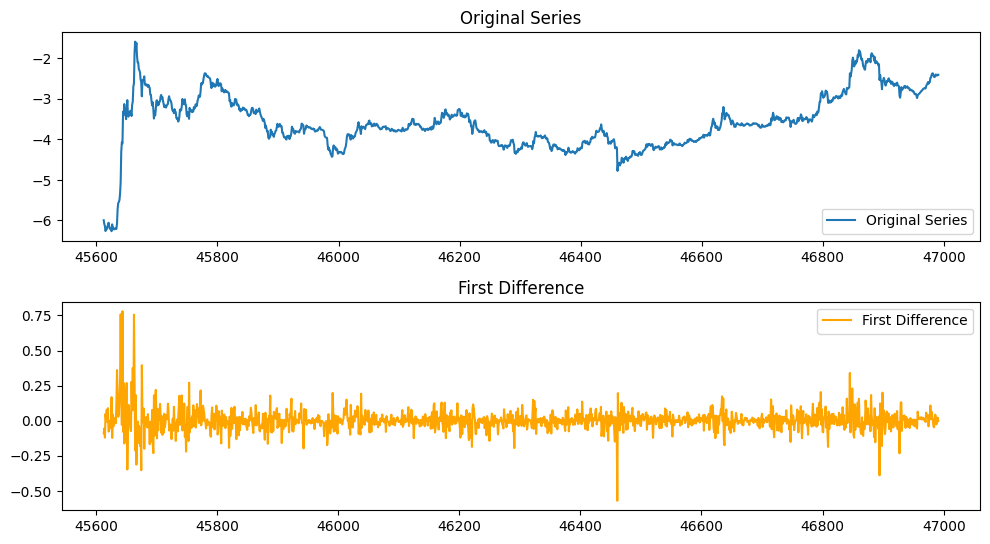

ADF Statistic for Cardano: -0.1601
p-value for Cardano: 0.9431
Critical Values:
   1%: -3.4353
   5%: -2.8637
   10%: -2.5679
ADF Statistic for Differenced Series (d=1): -17.2705
p-value for Differenced Series (d=1): 0.0000
Critical Values:
   1%: -3.4353
   5%: -2.8637
   10%: -2.5679

The series is stationary after 1 differencing(s).


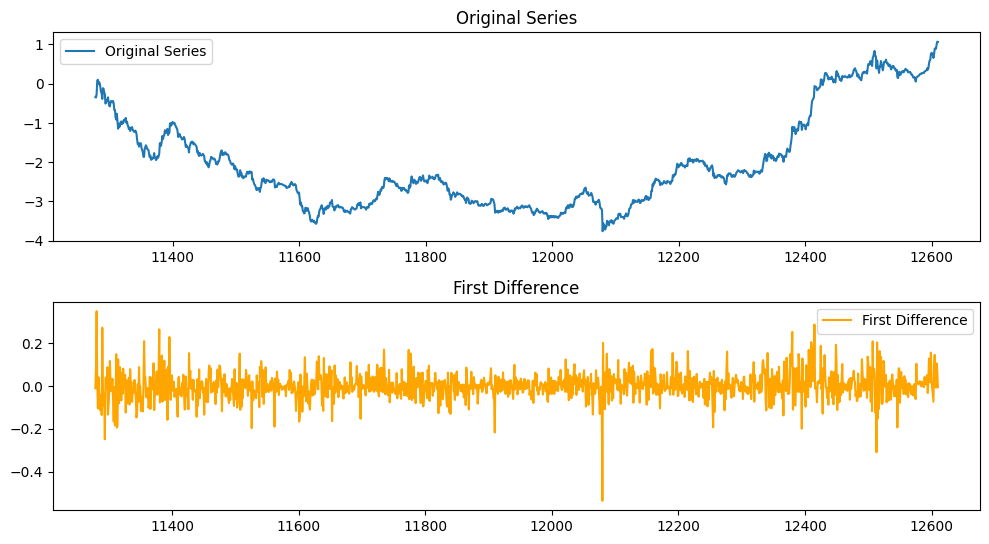

ADF Statistic for Polkadot: -0.8988
p-value for Polkadot: 0.7884
Critical Values:
   1%: -3.4485
   5%: -2.8695
   10%: -2.5710
ADF Statistic for Differenced Series (d=1): -9.1836
p-value for Differenced Series (d=1): 0.0000
Critical Values:
   1%: -3.4485
   5%: -2.8695
   10%: -2.5710

The series is stationary after 1 differencing(s).


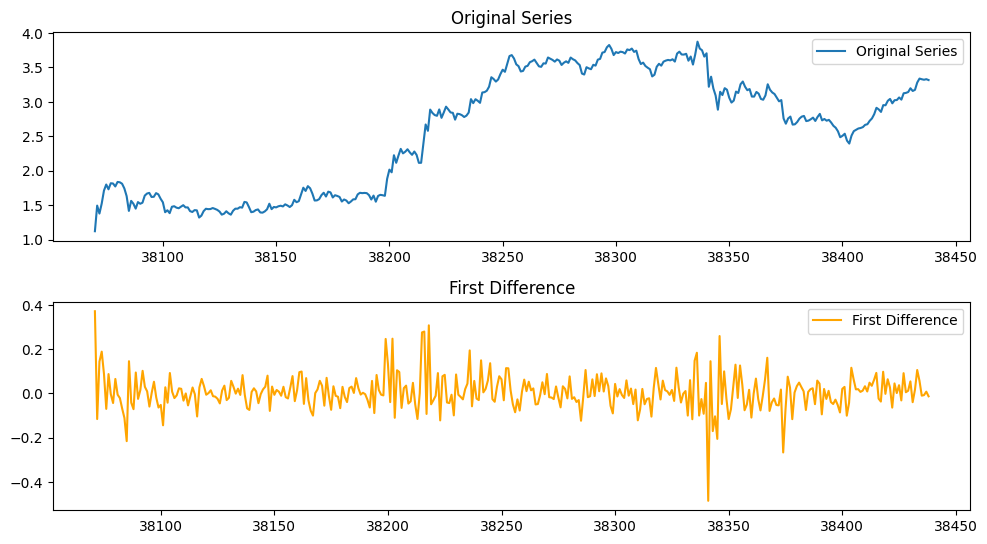

ADF Statistic for Avalanche: -2.7322
p-value for Avalanche: 0.0686
Critical Values:
   1%: -3.4580
   5%: -2.8737
   10%: -2.5733
ADF Statistic for Differenced Series (d=1): -6.5214
p-value for Differenced Series (d=1): 0.0000
Critical Values:
   1%: -3.4580
   5%: -2.8737
   10%: -2.5733

The series is stationary after 1 differencing(s).


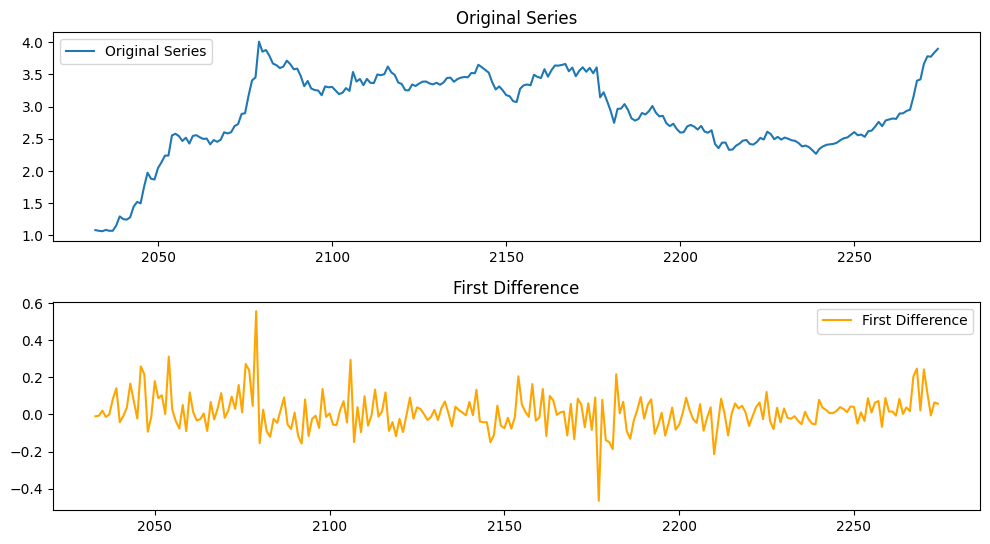

ADF Statistic for Chainlink: -0.2685
p-value for Chainlink: 0.9299
Critical Values:
   1%: -3.4354
   5%: -2.8638
   10%: -2.5680
ADF Statistic for Differenced Series (d=1): -40.0362
p-value for Differenced Series (d=1): 0.0000
Critical Values:
   1%: -3.4354
   5%: -2.8638
   10%: -2.5680

The series is stationary after 1 differencing(s).


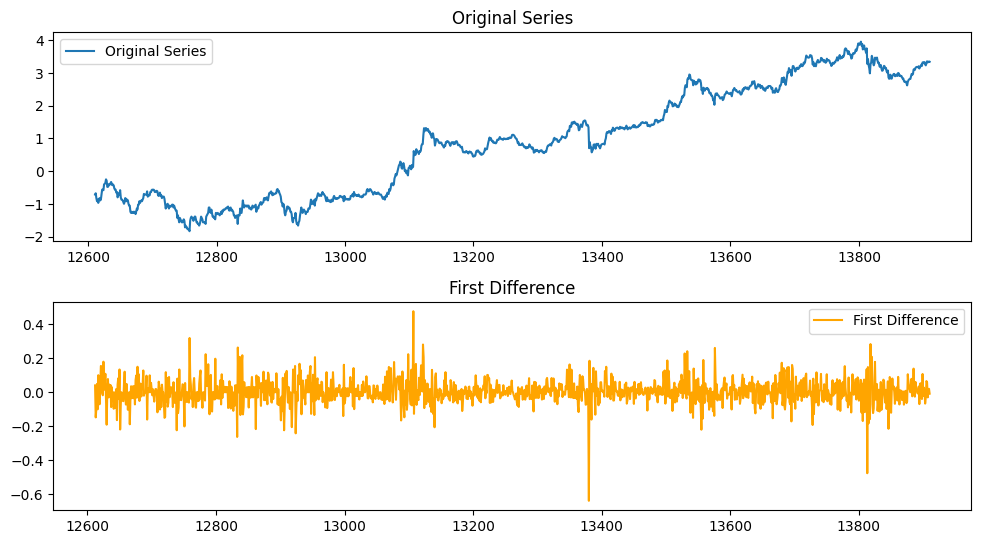

In [18]:
### Might not need this differencing as it's achieved in the SARIMAX model ###
# Filter coins
for coin in major_coins:
    series = coin['LogPrice']
    pvalue = adf_test(series, title=coin['Currency_Name'].iloc[0])

    # Set maximum differencing order to avoid over-differencing
    max_diff = 2
    d = 0
    diff_series = series.copy()

    # Iteratively difference the series until it appears stationary
    while pvalue > 0.05 and d <= max_diff:
        d += 1
        diff_series = diff_series.diff().dropna()
        pvalue = adf_test(diff_series, title=f'Differenced Series (d={d})')

    if pvalue <= 0.05:
        print(f'\nThe series is stationary after {d} differencing(s).')
    else:
        print(f'\nThe series is still non-stationary after {max_diff} differencing(s).')

    # Plot the original series and its differenced versions for visual inspection
    plt.figure(figsize=(10, 8))
    plt.subplot(311)
    plt.plot(series, label='Original Series')
    plt.title('Original Series')
    plt.legend()

    plt.subplot(312)
    plt.plot(series.diff(), label='First Difference', color='orange')
    plt.title('First Difference')
    plt.legend()

    if d >= 2:
        plt.subplot(313)
        plt.plot(series.diff().diff(), label='Second Difference', color='green')
        plt.title('Second Difference')
        plt.legend()

    plt.tight_layout()
    plt.show()

In [27]:
# Try BTC forecast first
df = sp500.copy()
data = df.merge(Bitcoin, on='Date', how='left')

# Look for the best grid (order)/grid search
X = data[['MeanPrice', 'Date']]     # Data for the S&P500
y = data[['Price']]                 # Data for Cryptocurrency
X = pd.get_dummies(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y , test_size=0.1, random_state=12, shuffle=False)

if 'Date' in X_train.columns:
    X_train = X_train.drop('Date', axis=1)
    X_test = X_test.drop('Date', axis=1)

# Define
p = d = q = range(0,3)
pdq = list(itertools.product(p, d, q))
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [116]:
import warnings
warnings.filterwarnings('ignore')

In [117]:
### Define a function to perform the grid search ###
def sarimax_gridsearch(pdq, pdqs, maxiter=5):
    """
    Search through all combinations of pdq and pdqs for the best SARIMAX paramters, based on the Bayesian Information Criterion (BIC).
    :param pdq: list of tuples, each representing the combination of (p, d, q)
    :param pdqs: list of tuples, each representing the combination of (P, D, Q, s)
    :param maxiter: maximum number of iterations
    :return: Best (pdq, pdqs) combination based on the lowest BIC
    """
    ans = []
    for comb in pdq:
        for combs in pdqs:
            try:
                mod = SARIMAX(y_train, exog=X_train, order=comb, seasonal_order=combs)
                output = mod.fit(maxiter=maxiter, disp=False)
                ans.append([comb, combs, output.bic])
                print('SARIMAX {} x {}: BIC ={}'.format(comb, combs, output.bic))
            except Exception as e:
                print("Error with SARIMAX order {} x {}: {}".format(comb, combs, e))
                continue

    # Convert the list of results to a DataFrame
    ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'bic'])
    ans_df = ans_df.sort_values('bic', ascending=True)

    # Print top 5 combinatoions for review
    print("\nTop combinations:")
    print(ans_df.head(5))

    # Select the best parameter combination (The one with lowest BIC)
    best_row = ans_df.iloc[0]

    return best_row['pdq'], best_row['pdqs']

In [119]:
# Now run the grid search
o, s = sarimax_gridsearch(pdq, pdqs, maxiter=20)

# create Exogenous variables
model = SARIMAX(y_train, exog=X_train, order=o, seasonal_order=s)
model_fit = model.fit(disp=False)
# Print a summary of the fitted model
summary = model_fit.summary()
print(summary)

KeyboardInterrupt: 

In [44]:
def forecast_from_model(model_fit, start_date, n_steps, future_exog=None, transform_func=np.exp):
    """
    Forecast future values from a fitted SARIMAX model and convert from log scale if needed.
    """
    end_date = start_date + timedelta(days=n_steps-1)
    forecast_obj = model_fit.get_forecast(steps=n_steps, exog=future_exog)
    forecast = forecast_obj.predicted_mean
    conf_int = forecast_obj.conf_int()

    # Apply transformation if needed
    forecast_converted = transform_func(forecast)
    conf_int_converted = conf_int.apply(transform_func)

    return forecast_converted, conf_int_converted

In [45]:
def plot_forecast(actual_series, forecast, conf_int, title='Forecast vs Actual'):
    """
    Plot the actual series and overlay the forecast with confidence intervals.
    """
    plt.figure(figsize=(10,8))
    plt.plot(actual_series.index, actual_series, label='Actual Price', color='blue')
    plt.plot(forecast.index, forecast, label='Forecasted Price', color='red')
    plt.fill_between(forecast.index,
                     conf_int.iloc[:, 0],
                     conf_int.iloc[:, 1],
                     color='pink', alpha=0.3)
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.title(title)
    plt.legend()
    plt.show()

In [46]:
def forecast_exog(series, forecast_steps, order=(1, 1, 1), seasonal_order=(0, 0, 0, 0), freq='D', transform_func=None):
    """
    Forecast future values for an exogenous time series using a SARIMAX model.
    """
    # Fit the SARIMAX model on the provided series
    model_exog = SARIMAX(series, order=order, seasonal_order=seasonal_order)
    model_exog_fit = model_exog.fit(disp=False)

    # Determine the forecast start date (one day after the last observation)
    forecast_start = series.index[-1] + timedelta(days=1)
    # Create a future date index for the forecast horizon.
    future_index = pd.date_range(start=forecast_start, periods=forecast_steps, freq=freq)

    # Get the forecast (point estimates and confidence intervals)
    forecast_obj = model_exog_fit.get_forecast(steps=forecast_steps)
    forecast_values = forecast_obj.predicted_mean
    conf_int = forecast_obj.conf_int()

    # Re-index the forecast results so that they use the new future date index.
    forecast_values.index = future_index
    conf_int.index = future_index

    # Apply a transformation if needed (e.g., convert from log scale)
    if transform_func is not None:
        forecast_values = transform_func(forecast_values)
        # Apply the transformation to each column of the confidence interval DataFrame.
        conf_int = conf_int.apply(transform_func)

    return forecast_values, conf_int

In [96]:
model_fit = []
sp500['Return'] = sp500['MeanPrice'].pct_change().fillna(method='ffill')
for coin in major_coins:
    # 1) Build y as a Date‑indexed series of log‑prices
    y = coin.set_index('Date')['LogPrice'].sort_index()

    # 2) Align the exog to that same index, forward‑ & back‑fill any gaps
    X = (sp500[['Return']]
         .reindex(y.index)    # ← force SP500 to have exactly the same dates
         .ffill()             # carry last known value forward
         .bfill()             # carry first known value backward
    )

    # Sanity check:
    assert y.shape[0] == X.shape[0]
    assert not X['Return'].isna().any()

    # 3) Fit the SARIMAX with perfectly aligned y & X
    model = SARIMAX(y,
                    exog=X,
                    order=(0,1,0),
                    seasonal_order=(0,2,2,12),
                    enforce_stationarity=False,
                    enforce_invertibility=False)
    fit = model.fit(disp=False)
    model_fit.append((coin, fit))

# Forecast future prices
n_steps = 100  # forecast the next 100 days

# For forecasting exogenous variable, we use the mean SP500_Return (or another appropriate forecast)
sp500_returns = sp500['Return'].dropna()
future_exog_forecast, future_exog_conf = forecast_exog(sp500_returns, forecast_steps=n_steps, order=(1,1,1), seasonal_order=(0,0,0,0), freq='D', transform_func=None)

# Forecast and plot
fc_data = []
for coin, fit in model_fit:
    fc_obj = fit.get_forecast(steps=n_steps, exog=future_exog_forecast)
    fc_log    = fc_obj.predicted_mean
    fc_ci     = fc_obj.conf_int()

    # back to price
    fc_price  = np.exp(fc_log)
    fc_price.index = future_exog_forecast.index
    lower_pi  = np.exp(fc_ci.iloc[:, 0])
    upper_pi  = np.exp(fc_ci.iloc[:, 1])

    fc_data.append((coin, fc_price, lower_pi, upper_pi))

/var/folders/57/61ph47l57xbcttcf_1d33p9m0000gn/T/ipykernel_1976/2380853505.py:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  sp500['Return'] = sp500['MeanPrice'].pct_change().fillna(method='ffill')
/Users/corinnama/PycharmProjects/PHY408 Labs/.venv/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/corinnama/PycharmProjects/PHY408 Labs/.venv/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/corinnama/PycharmProjects/PHY408 Labs/.venv/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.

In [110]:
btc_hist = pd.read_csv('BitcoinHistoricalData.csv')
btc_hist['Date'] = pd.to_datetime(btc_hist['Date'])
btc_hist['Decimal_Year'] = btc_hist['Date'].dt.year + (btc_hist['Date'].dt.dayofyear - 1) / 365
btc_mask = (btc_hist['Decimal_Year'] >= 2021.7) & (btc_hist['Decimal_Year'] <= 2022.0)

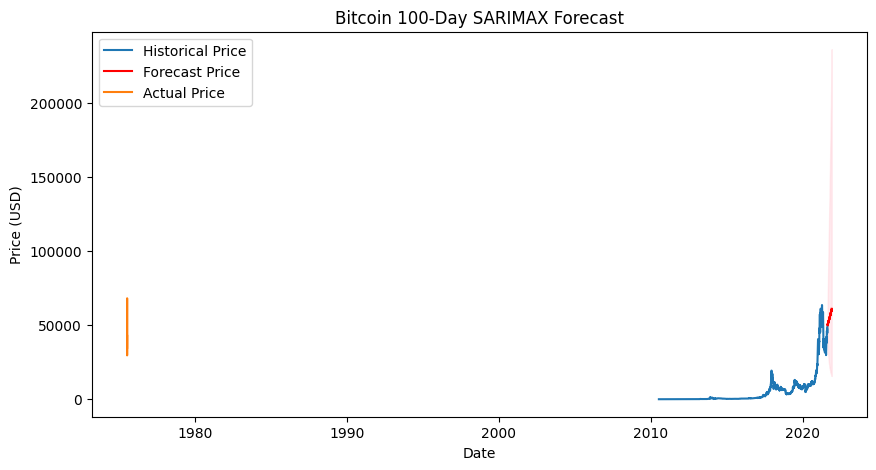

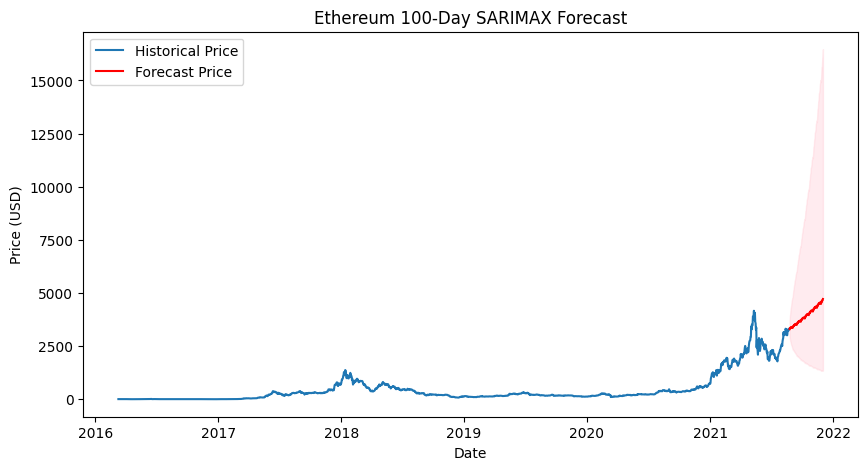

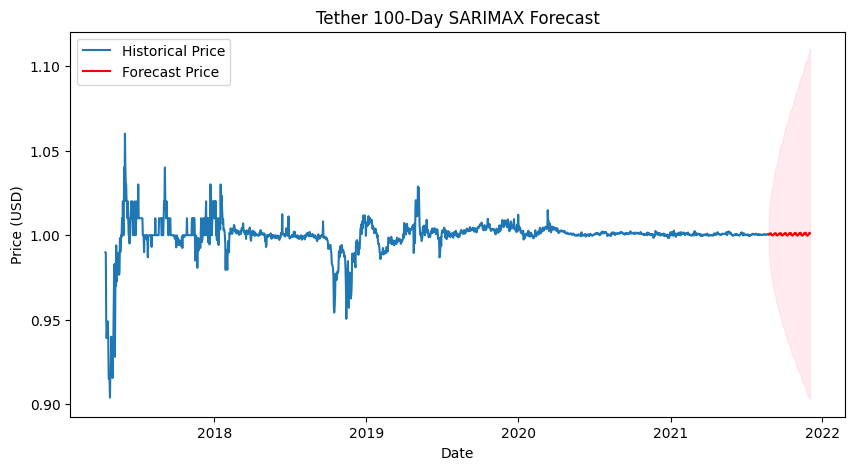

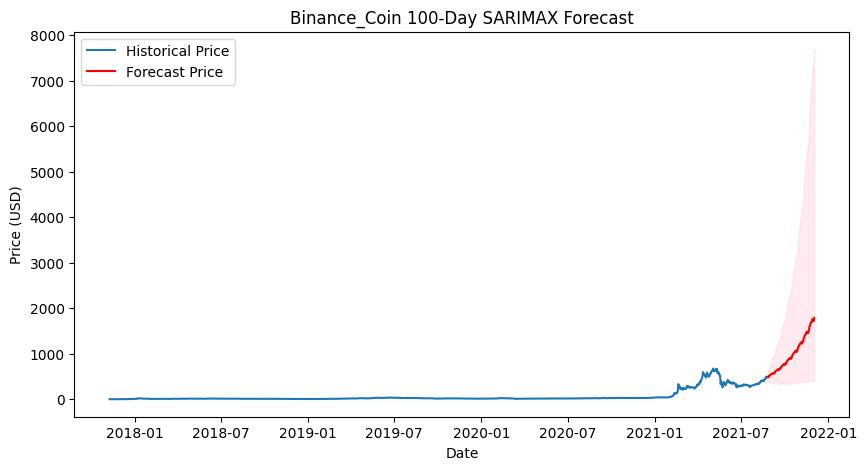

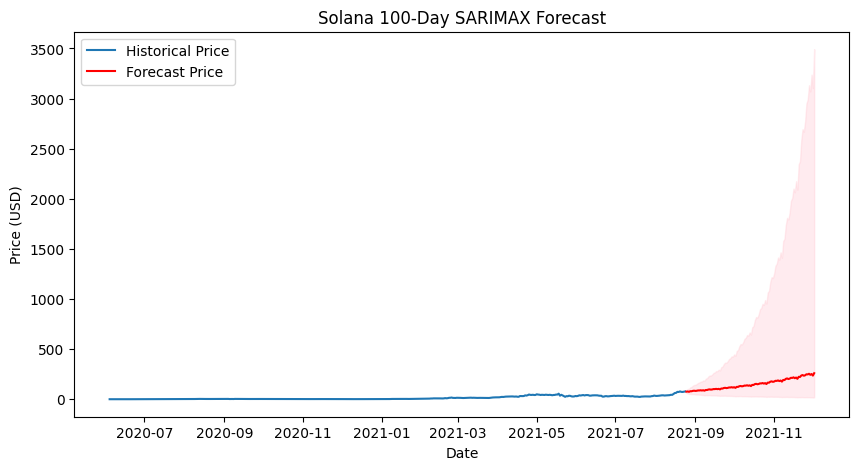

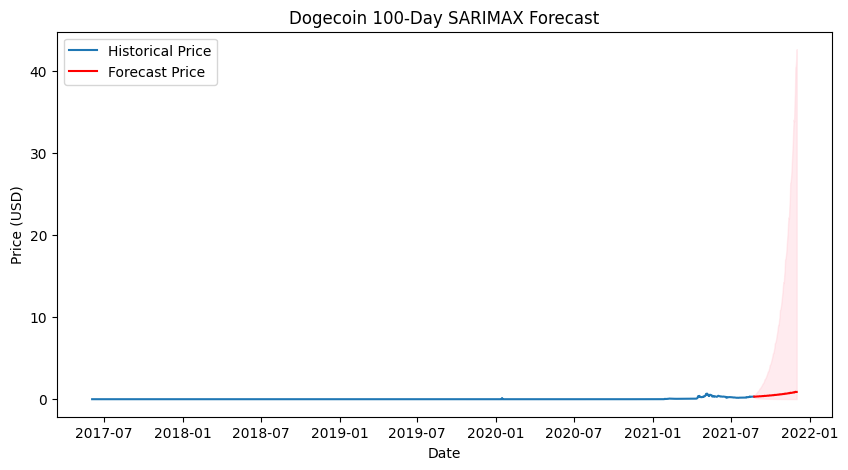

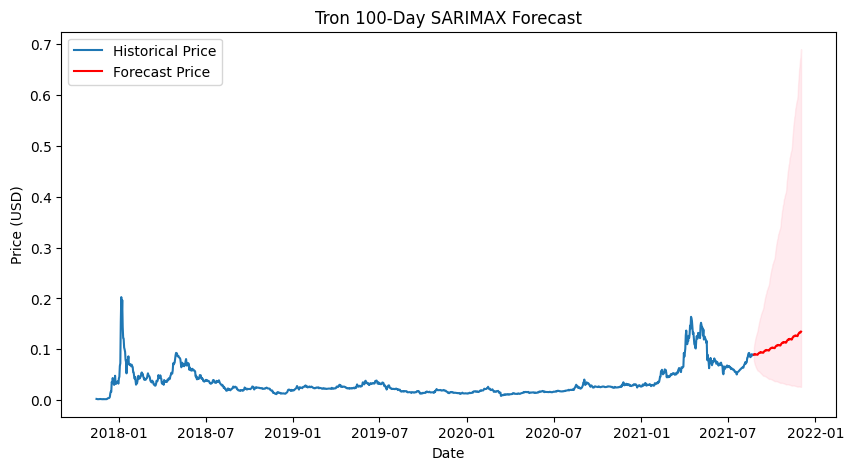

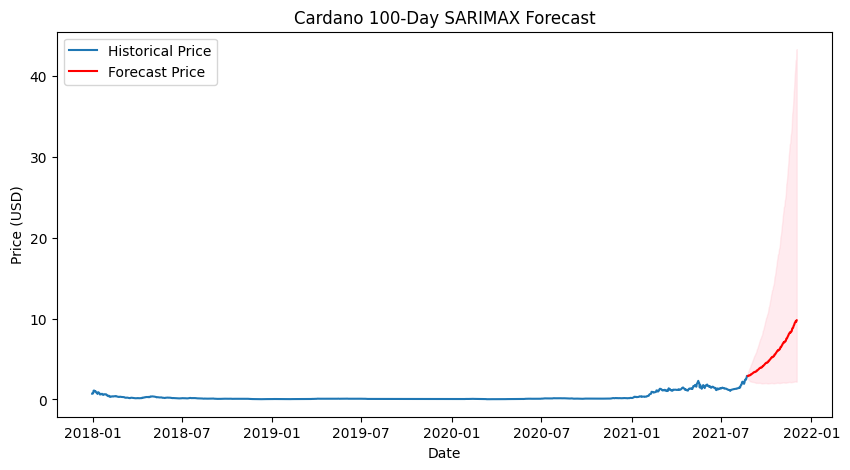

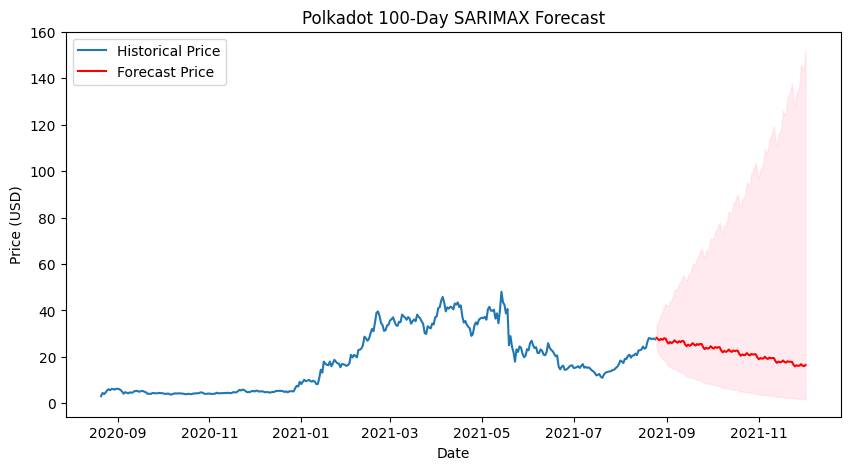

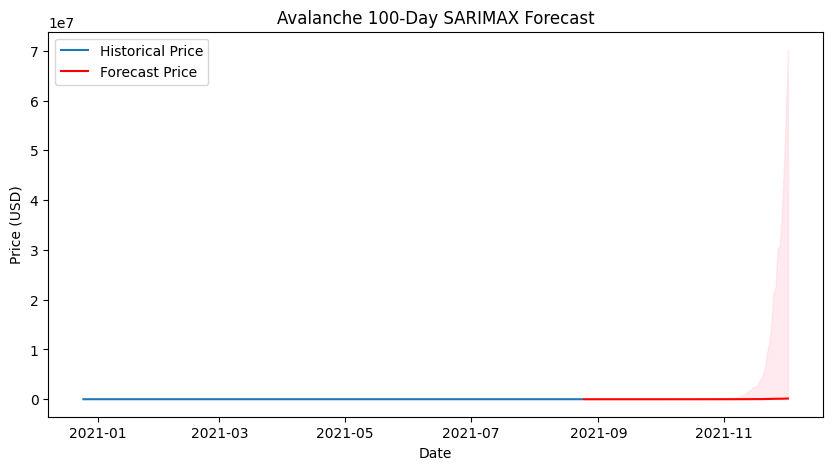

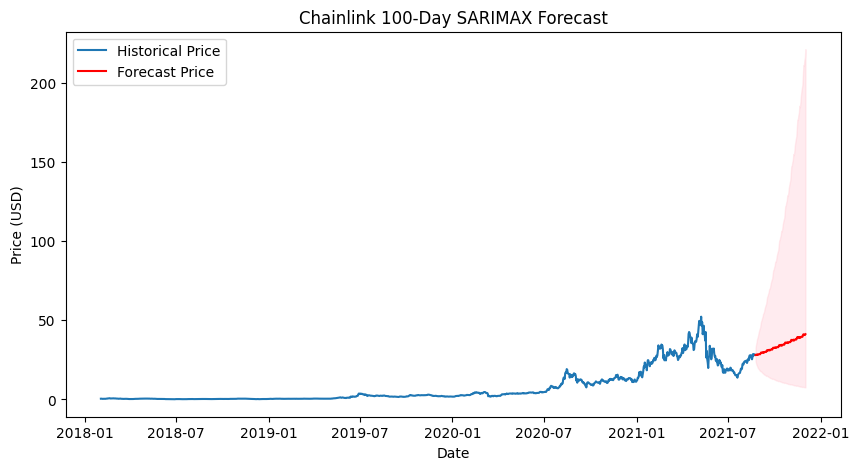

In [107]:
for coin, fc_price, lower_pi, upper_pi in fc_data:
    # plot
    plt.figure(figsize=(10, 5))
    plt.plot(coin['Date'], coin['Price'], label='Historical Price')
    plt.plot(fc_price.index, fc_price, color='red', label='Forecast Price')
    plt.fill_between(fc_price.index, lower_pi, upper_pi, color='pink', alpha=0.3)
    if coin['Currency_Name'].iloc[0] == 'Bitcoin':
        btc_hist_filtered = btc_hist[btc_mask]
        plt.plot(btc_hist_filtered['Decimal_Year'], btc_hist_filtered['Close'], label='Actual Price')
    plt.title(f"{coin['Currency_Name'].iloc[0]} 100‑Day SARIMAX Forecast")
    plt.xlabel('Date')
    plt.ylabel('Price (USD)')
    plt.legend()
    plt.savefig(f"100‑Day SARIMAX Forecast {coin['Currency_Name'].iloc[0]}.png")
    plt.show()

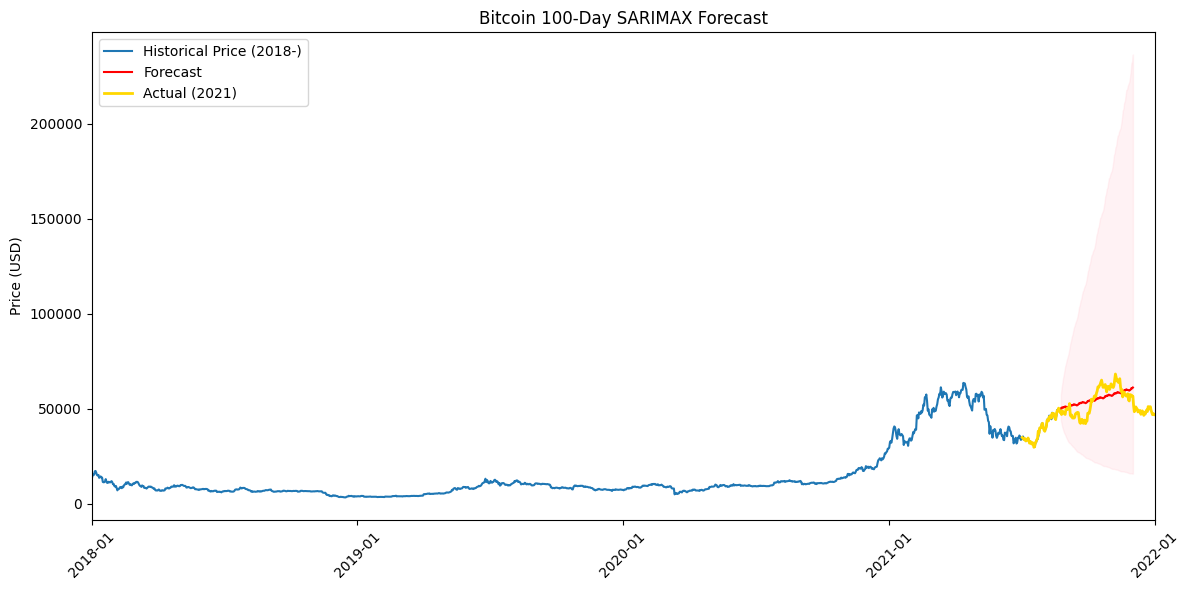

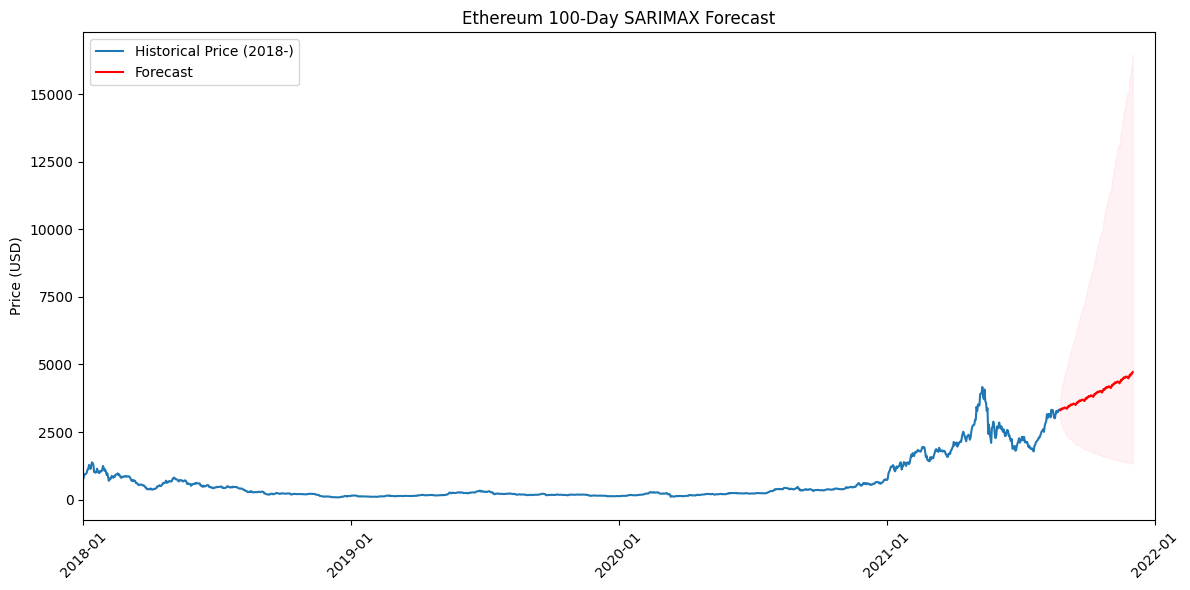

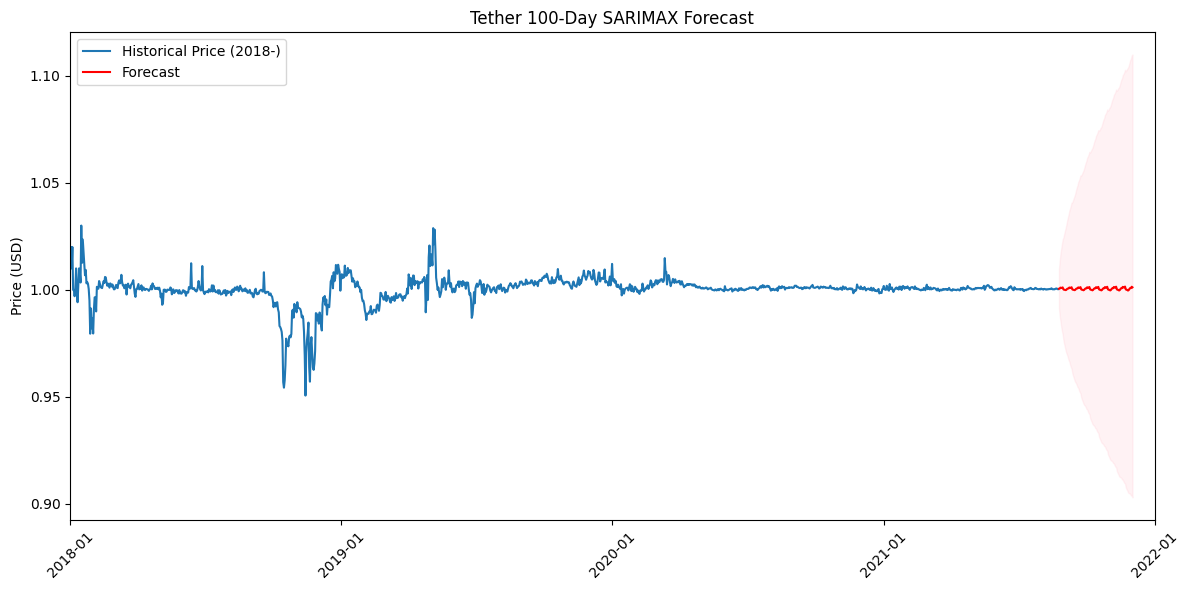

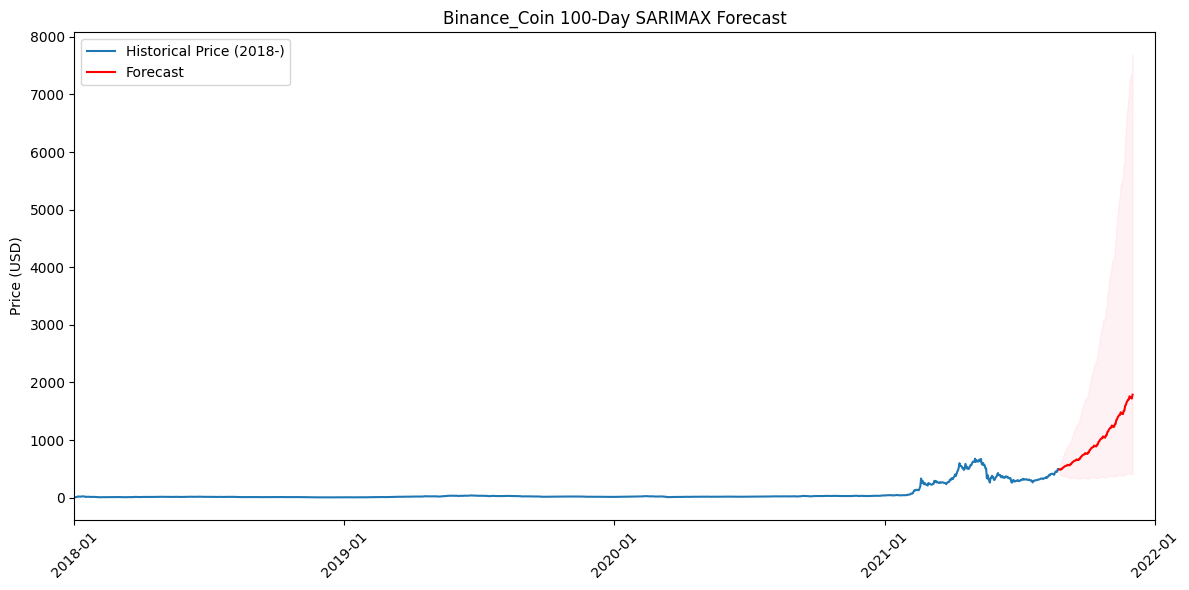

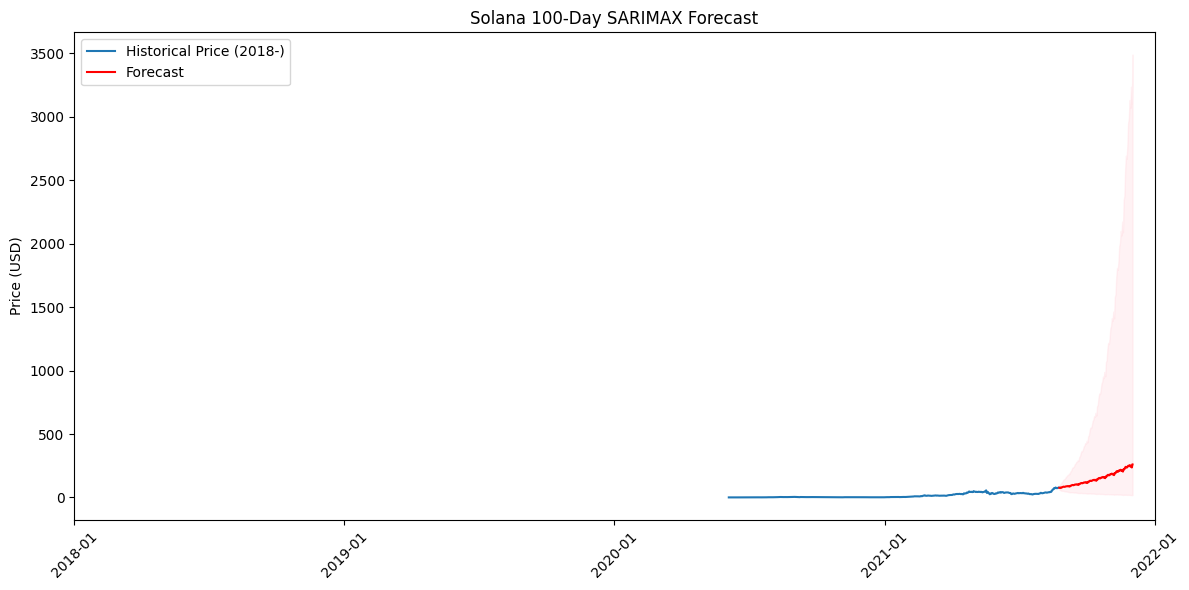

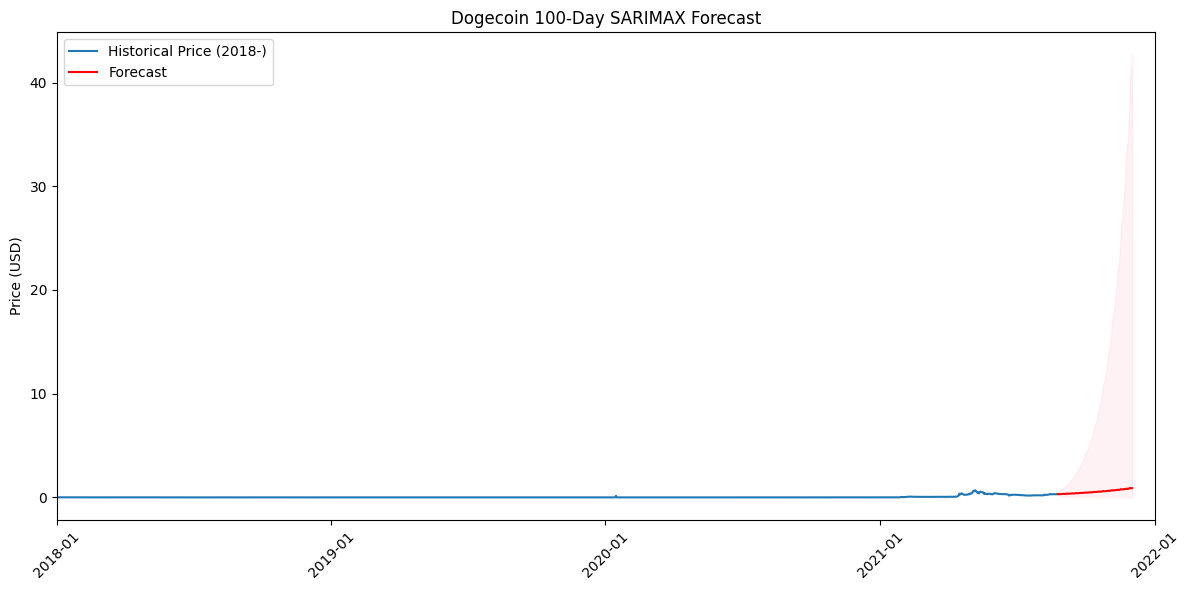

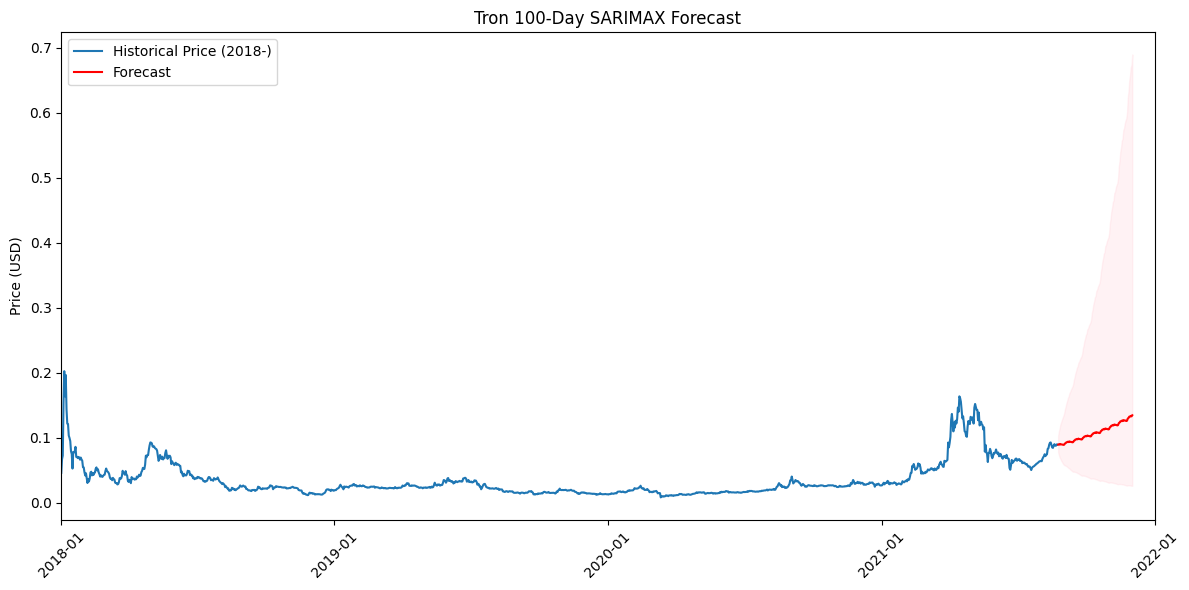

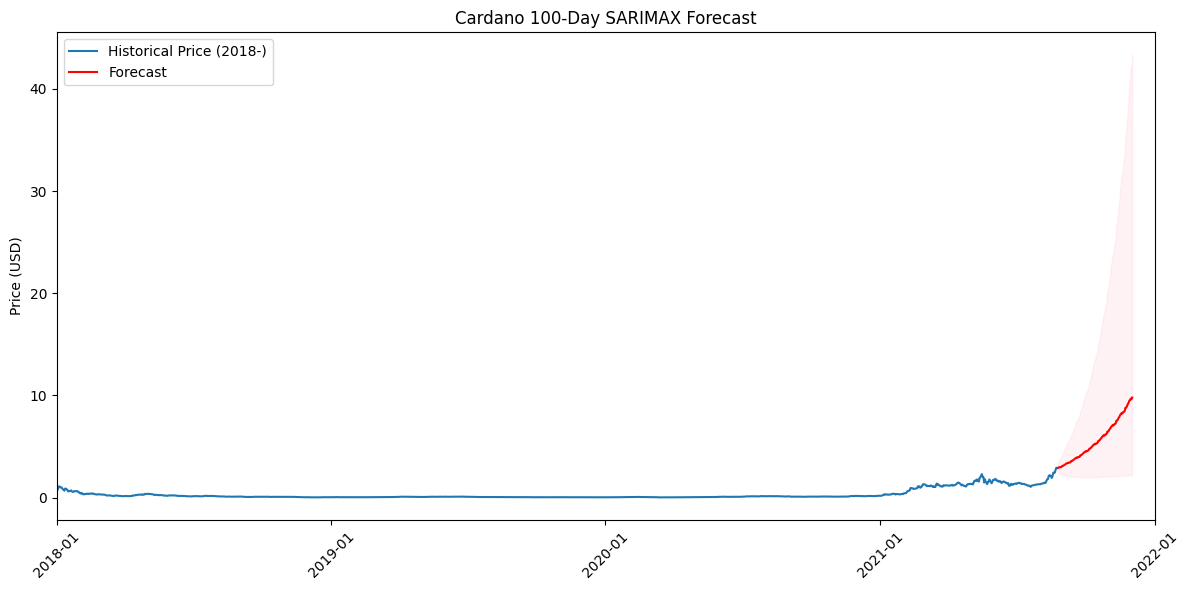

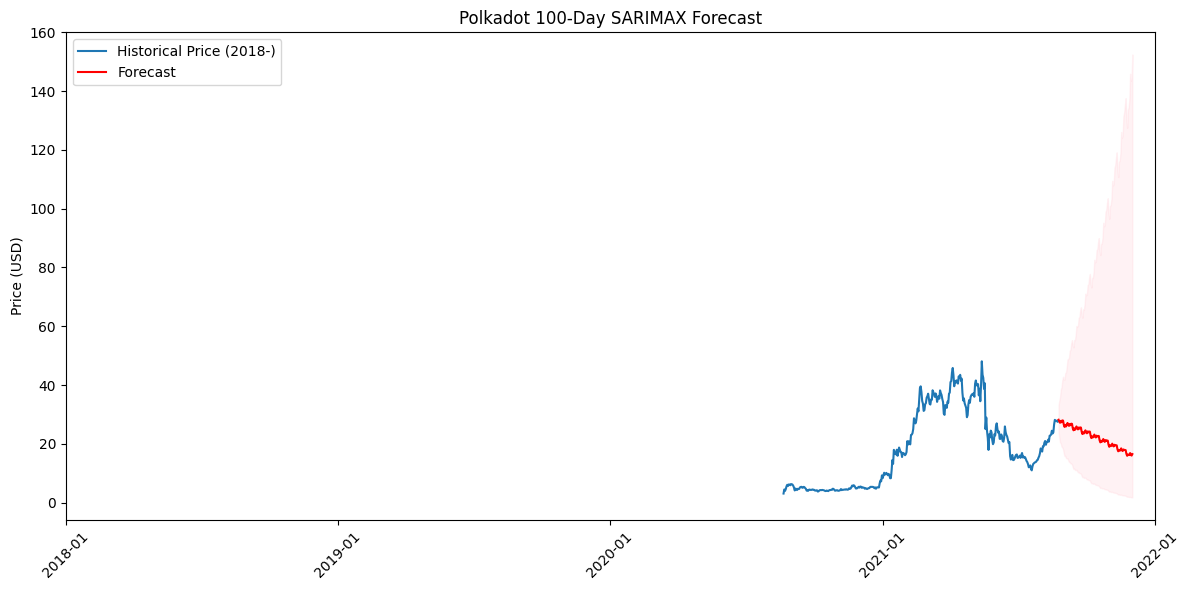

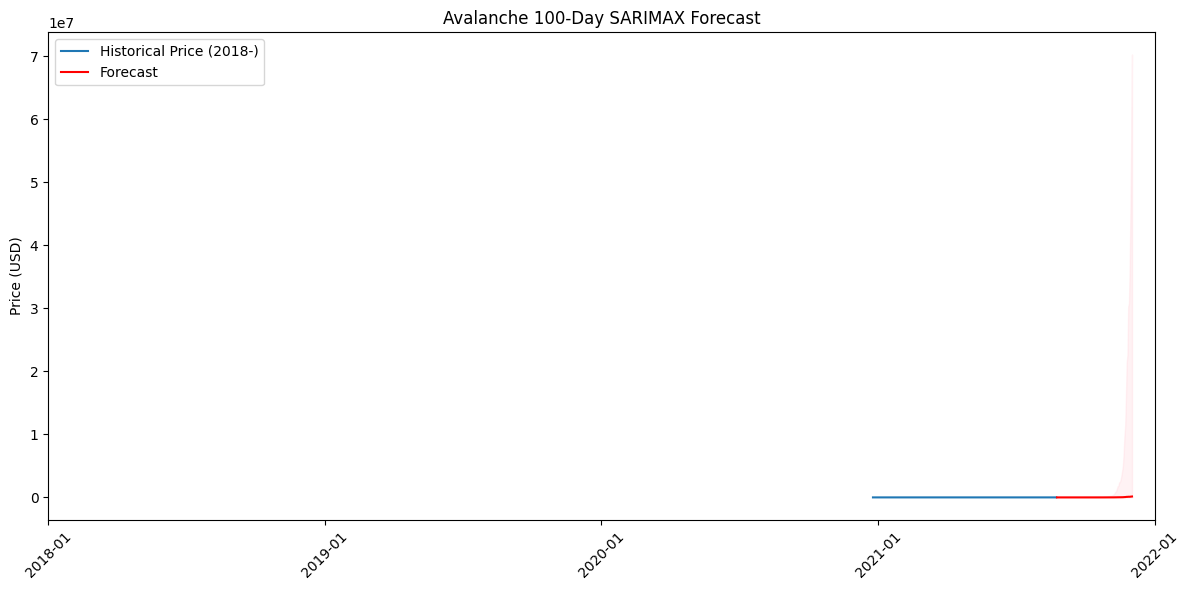

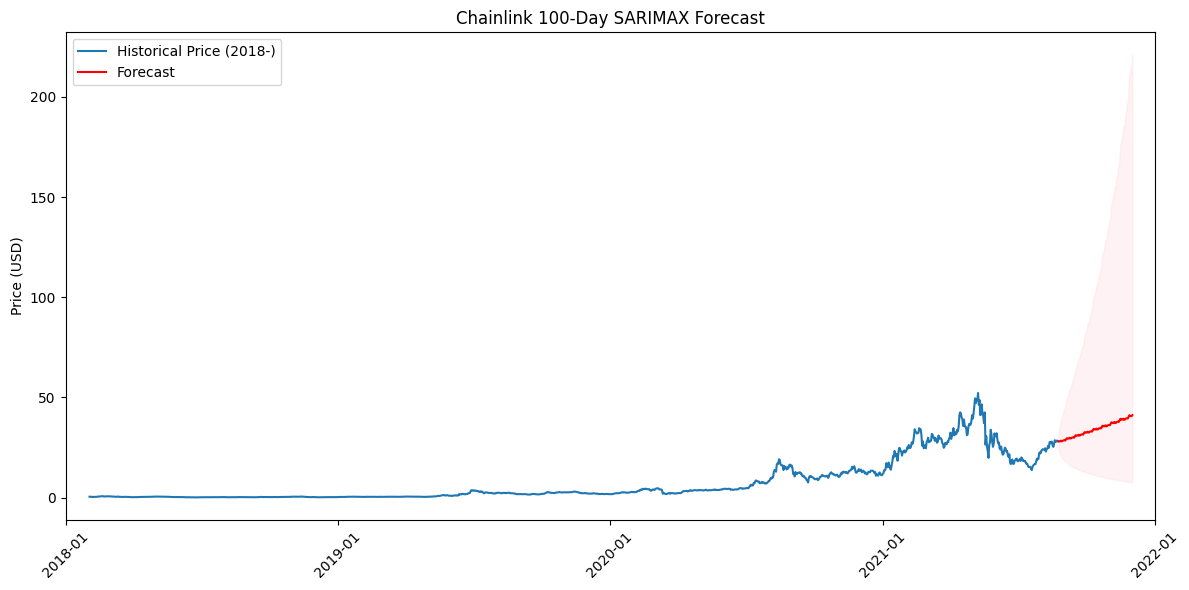

In [111]:
for coin, fc_price, lower_pi, upper_pi in fc_data:
    plt.figure(figsize=(12, 6))

    # Convert all x-axis values to datetime if needed
    if not pd.api.types.is_datetime64_any_dtype(coin['Date']):
        coin['Date'] = pd.to_datetime(coin['Date'])

    # Plot historical data (last 3 years only for clarity)
    historical_mask = coin['Date'] >= pd.to_datetime('2018-01-01')
    plt.plot(coin.loc[historical_mask, 'Date'],
             coin.loc[historical_mask, 'Price'],
             label='Historical Price (2018-)')

    # Plot forecast
    plt.plot(fc_price.index, fc_price, 'r-', label='Forecast')
    plt.fill_between(fc_price.index, lower_pi, upper_pi, color='pink', alpha=0.2)

    # Add Bitcoin actual price (if applicable)
    if coin['Currency_Name'].iloc[0] == 'Bitcoin':
        # Convert decimal years to datetime
        btc_dates = pd.to_datetime((btc_hist_filtered['Decimal_Year'] - 1970) * 365.25, unit='D')
        plt.plot(btc_dates,
                 btc_hist_filtered['Close'],
                 'gold', linewidth=2, label='Actual (2021)')

    # Format x-axis
    plt.xlim(pd.to_datetime('2018-01-01'), fc_price.index.max() + pd.Timedelta(days=30))
    plt.gca().xaxis.set_major_locator(mdates.YearLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

    plt.title(f"{coin['Currency_Name'].iloc[0]} 100-Day SARIMAX Forecast")
    plt.ylabel('Price (USD)')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()

    plt.savefig(f"SARIMAX_Forecast_{coin['Currency_Name'].iloc[0]}.png", dpi=300)
    plt.show()